In [1]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from hmmlearn.hmm import GaussianHMM
from scipy.stats import shapiro
from itertools import product

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pandas_ta as ta
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings('ignore')

DATA CLEANING

Data gathered from Kaggle: https://www.kaggle.com/datasets/jakewright/9000-tickers-of-stock-market-data-full-history
- Covers over 9000 tickers from 1962 to 2024
- 4.47 GB

In [2]:
#Using parquet because massive dataset
df = pd.read_parquet("../data/all_stock_data.parquet", engine="pyarrow")
df["Date"] = pd.to_datetime(df["Date"])
df

Date Ticker       Open       High        Low      Close  \
0        1962-01-02     ED   0.000000   0.265828   0.261788   0.261788   
1        1962-01-02    CVX   0.000000   0.046809   0.046069   0.046809   
2        1962-01-02     GD   0.000000   0.210033   0.203061   0.208290   
3        1962-01-02     BP   0.000000   0.141439   0.139528   0.139528   
4        1962-01-02    MSI   0.000000   0.764923   0.745254   0.751810   
...             ...    ...        ...        ...        ...        ...   
34646253 2024-11-04   NEOG  14.490000  14.580000  14.340000  14.345000   
34646254 2024-11-04   ENLV   1.400000   1.428900   1.330000   1.350000   
34646255 2024-11-04   FAMI   0.320000   0.320000   0.300100   0.300100   
34646256 2024-11-04    NNN  43.730000  43.439999  43.209999  43.244999   
34646257 2024-11-04   SHOO  44.740002  45.150002  44.724998  45.000000   

             Volume  Dividends  Stock Splits  
0           25600.0        0.0           0.0  
1          105840.0        0.0           0.0  
2         2648000.0        0.0           0.0  
3           77440.0        0.0           0.0  
4           65671.0        0.0           0.0  
...             ...        ...           ...  
34646253    18972.0        0.0           0.0  
34646254    28794.0        0.0           0.0  
34646255    77650.0        0.0           0.0  
34646256    88675.0        0.0           0.0  
34646257    26010.0        0.0           0.0  

[34646258 rows x 9 columns]

In [3]:
df['Volume'].median()

53800.0

In [4]:
# Filter for recent rows only
cutoff = df["Date"].max() - timedelta(days=45)
df_recent = df[df["Date"] >= cutoff]

# Keep rows with valid Close and Volume only
df_recent = df_recent[(df_recent["Close"].notna()) & (df_recent["Volume"].notna())]

# Compute per-ticker stats (last close + avg volume)
summary = (
    df_recent.groupby("Ticker")
    .agg(LastPrice=('Close', 'last'), AvgVolume=('Volume', 'mean'))
)
# Filter by liquidity and price
filtered = summary.query("AvgVolume > 427_000 and LastPrice > 5")

# Get top 100 by average volume (faster than sort + head)
top_tickers = filtered.nlargest(100, "AvgVolume").index.tolist()

# Final filtered dataset
df_top100 = df[df["Ticker"].isin(top_tickers)]
df_top100

Date Ticker       Open       High        Low      Close  \
17       1962-01-02     BA   0.190311   0.190311   0.187037   0.187037   
23       1962-01-02     KO   0.004007   0.004116   0.004007   0.004007   
27       1962-01-02    XOM   0.000000   0.101537   0.100789   0.100789   
41       1962-01-03     BA   0.189843   0.193584   0.189843   0.190778   
42       1962-01-03    XOM   0.000000   0.102286   0.100789   0.102286   
...             ...    ...        ...        ...        ...        ...   
34645932 2024-11-04   HOOD  23.750000  23.900000  23.540100  23.889999   
34645942 2024-11-04    CSX  33.470001  33.805000  33.369999  33.770000   
34645985 2024-11-04    FCX  45.599998  46.160000  45.626900  46.110001   
34646132 2024-11-04   ITUB   6.060000   6.165000   6.125000   6.160000   
34646157 2024-11-04    SLB  40.160000  40.349998  39.930000  40.340000   

             Volume  Dividends  Stock Splits  
17         352350.0        0.0           0.0  
23         806400.0        0.0           0.0  
27         902400.0        0.0           0.0  
41         710775.0        0.0           0.0  
42        1200000.0        0.0           0.0  
...             ...        ...           ...  
34645932  1394526.0        0.0           0.0  
34645942   680096.0        0.0           0.0  
34645985   487766.0        0.0           0.0  
34646132   987570.0        0.0           0.0  
34646157   567642.0        0.0           0.0  

[606032 rows x 9 columns]

In [5]:
df_top100 = df_top100.reset_index(drop=True)
df_top100

Date Ticker       Open       High        Low      Close  \
0      1962-01-02     BA   0.190311   0.190311   0.187037   0.187037   
1      1962-01-02     KO   0.004007   0.004116   0.004007   0.004007   
2      1962-01-02    XOM   0.000000   0.101537   0.100789   0.100789   
3      1962-01-03     BA   0.189843   0.193584   0.189843   0.190778   
4      1962-01-03    XOM   0.000000   0.102286   0.100789   0.102286   
...           ...    ...        ...        ...        ...        ...   
606027 2024-11-04   HOOD  23.750000  23.900000  23.540100  23.889999   
606028 2024-11-04    CSX  33.470001  33.805000  33.369999  33.770000   
606029 2024-11-04    FCX  45.599998  46.160000  45.626900  46.110001   
606030 2024-11-04   ITUB   6.060000   6.165000   6.125000   6.160000   
606031 2024-11-04    SLB  40.160000  40.349998  39.930000  40.340000   

           Volume  Dividends  Stock Splits  
0        352350.0        0.0           0.0  
1        806400.0        0.0           0.0  
2        902400.0        0.0           0.0  
3        710775.0        0.0           0.0  
4       1200000.0        0.0           0.0  
...           ...        ...           ...  
606027  1394526.0        0.0           0.0  
606028   680096.0        0.0           0.0  
606029   487766.0        0.0           0.0  
606030   987570.0        0.0           0.0  
606031   567642.0        0.0           0.0  

[606032 rows x 9 columns]

Feature Engineering

Adding calculated indicators:
- RSI: relative strength index (momentum)
- SMA20: 20-day single moving average (trend)
- MACD: moving average convergence divergence (momentum)
- ATR: average true range (volitility)
- Daily Return: percent change in close price
- Bollinger Band Percent: position within upper/lower bands
- Price to SMA: price relative to 20 day SMA
- Close to open ratio (intraday momentum/sentiment)
- Volume z: z-score normalized rolling 20-day volume

Then scaling all of the values using StandardScalar()

In [6]:
def add_indicators(df):
    df = df.sort_values("Date") 
    df["rsi"] = ta.rsi(df["Close"], length=14)
    df["sma20"] = ta.sma(df["Close"], length=20)
    df["macd"] = ta.macd(df["Close"])["MACD_12_26_9"]
    df["atr"] = ta.atr(df["High"], df["Low"], df["Close"])
    df["daily_return"] = df["Close"].pct_change()
    bbands = ta.bbands(df["Close"], length=20)
    df["bb_percent"] = bbands["BBP_20_2.0"]
    df["price_to_sma"] = df["Close"] / df["sma20"]
    df["co_ratio"] = df["Close"] / df["Open"]
    df["volume_z"] = (df["Volume"] - df["Volume"].mean()) / df["Volume"].std()
    return df

df_features = df_top100.groupby("Ticker", group_keys=False).apply(add_indicators).dropna(subset=["rsi", "sma20", "macd", "atr"]).reset_index(drop=True)
df_features 

Date Ticker       Open       High        Low      Close  \
0      1962-02-06    XOM   0.000000   0.110768   0.109271   0.109521   
1      1962-02-06     KO   0.003769   0.003769   0.003719   0.003719   
2      1962-02-06     BA   0.205256   0.205728   0.200066   0.205256   
3      1962-02-07     BA   0.205256   0.209031   0.203841   0.205256   
4      1962-02-07    XOM   0.000000   0.110479   0.108714   0.110479   
...           ...    ...        ...        ...        ...        ...   
603515 2024-11-04   HOOD  23.750000  23.900000  23.540100  23.889999   
603516 2024-11-04    CSX  33.470001  33.805000  33.369999  33.770000   
603517 2024-11-04    FCX  45.599998  46.160000  45.626900  46.110001   
603518 2024-11-04   ITUB   6.060000   6.165000   6.125000   6.160000   
603519 2024-11-04    SLB  40.160000  40.349998  39.930000  40.340000   

           Volume  Dividends  Stock Splits        rsi      sma20      macd  \
0       1446400.0    0.00000           0.0  75.646111   0.103284  0.003284   
1        691200.0    0.00000           0.0  45.517039   0.003728 -0.000058   
2        801900.0    0.00000           0.0  65.384446   0.198258  0.007225   
3        844425.0    0.00000           0.0  65.384446   0.199216  0.006874   
4       1126400.0    0.01875           0.0  77.559897   0.103843  0.003396   
...           ...        ...           ...        ...        ...       ...   
603515  1394526.0    0.00000           0.0  42.221555  26.387000  0.453875   
603516   680096.0    0.00000           0.0  49.148475  33.970500 -0.192415   
603517   487766.0    0.00000           0.0  44.584281  47.554500 -0.401666   
603518   987570.0    0.00000           0.0  45.167088   6.199500 -0.098237   
603519   567642.0    0.00000           0.0  38.979635  42.329500 -0.832463   

             atr  daily_return  bb_percent  price_to_sma  co_ratio  volume_z  
0       0.001415     -0.013483    0.948958      1.060387       inf -0.843747  
1       0.000081     -0.013157    0.480739      0.997608  0.986843 -1.082624  
2       0.004999      0.000000    0.731260      1.035300  1.000000 -0.569059  
3       0.005015      0.000000    0.710682      1.030323  1.000000 -0.560594  
4       0.001444      0.008752    0.950844      1.063905       inf -0.877327  
...          ...           ...         ...           ...       ...       ...  
603515  1.199428     -0.003338    0.023611      0.905370  1.005895 -0.994192  
603516  0.666130      0.011381    0.434500      0.994098  1.008963 -1.045723  
603517  1.241925      0.011406    0.225274      0.969624  1.011184 -0.999150  
603518  0.130932      0.037037    0.395820      0.993628  1.016502 -1.297856  
603519  0.975102      0.014588    0.201039      0.953000  1.004482 -1.199989  

[603520 rows x 18 columns]

In [7]:

features_to_use = ["rsi", "sma20", "macd", "atr", "daily_return", "bb_percent", "price_to_sma", "co_ratio", "volume_z"]
df_features = df_top100.groupby("Ticker", group_keys=False).apply(add_indicators).dropna(subset=features_to_use).reset_index(drop=True)

# Remove inf/-inf and large magnitude outliers
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# cap extreme values
df_features = df_features[df_features[features_to_use].abs().lt(1e10).all(axis=1)]

# Drop remaining NaNs
df_features.dropna(subset=features_to_use, inplace=True)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features[features_to_use])

# Add scaled versions to dataframe
scaled_cols = [f"{col}_scaled" for col in features_to_use]
df_features[scaled_cols] = features_scaled

df_features

Date Ticker       Open       High        Low      Close  \
1      1962-02-06     KO   0.003769   0.003769   0.003719   0.003719   
2      1962-02-06     BA   0.205256   0.205728   0.200066   0.205256   
3      1962-02-07     BA   0.205256   0.209031   0.203841   0.205256   
5      1962-02-07     KO   0.003719   0.003739   0.003719   0.003739   
7      1962-02-08     BA   0.205728   0.209031   0.205728   0.205728   
...           ...    ...        ...        ...        ...        ...   
603515 2024-11-04   HOOD  23.750000  23.900000  23.540100  23.889999   
603516 2024-11-04    CSX  33.470001  33.805000  33.369999  33.770000   
603517 2024-11-04    FCX  45.599998  46.160000  45.626900  46.110001   
603518 2024-11-04   ITUB   6.060000   6.165000   6.125000   6.160000   
603519 2024-11-04    SLB  40.160000  40.349998  39.930000  40.340000   

           Volume  Dividends  Stock Splits        rsi  ...  volume_z  \
1        691200.0        0.0           0.0  45.517039  ... -1.082624   
2        801900.0        0.0           0.0  65.384446  ... -0.569059   
3        844425.0        0.0           0.0  65.384446  ... -0.560594   
5        192000.0        0.0           0.0  47.470303  ... -1.145577   
7        656100.0        0.0           0.0  66.102568  ... -0.598085   
...           ...        ...           ...        ...  ...       ...   
603515  1394526.0        0.0           0.0  42.221555  ... -0.994192   
603516   680096.0        0.0           0.0  49.148475  ... -1.045723   
603517   487766.0        0.0           0.0  44.584281  ... -0.999150   
603518   987570.0        0.0           0.0  45.167088  ... -1.297856   
603519   567642.0        0.0           0.0  38.979635  ... -1.199989   

        rsi_scaled  sma20_scaled  macd_scaled  atr_scaled  \
1        -0.523545     -0.039800     0.015255   -0.037813   
2         1.097999     -0.039777     0.015267   -0.037804   
3         1.097999     -0.039777     0.015266   -0.037804   
5        -0.364123     -0.039800     0.015255   -0.037814   
7         1.156611     -0.039776     0.015266   -0.037804   
...            ...           ...          ...         ...   
603515   -0.792517     -0.036599     0.016016   -0.035429   
603516   -0.227153     -0.035679     0.014932   -0.036489   
603517   -0.599675     -0.034030     0.014581   -0.035345   
603518   -0.552108     -0.039048     0.015090   -0.037553   
603519   -1.057117     -0.034664     0.013859   -0.035875   

        daily_return_scaled  bb_percent_scaled  price_to_sma_scaled  \
1                 -0.448115          -0.166291            -0.098431   
2                 -0.026793           0.586808             0.420899   
3                 -0.026793           0.524947             0.352324   
5                  0.143994           0.025860             0.006188   
7                  0.046791           0.512209             0.321818   
...                     ...                ...                  ...   
603515            -0.133672          -1.540481            -1.369285   
603516             0.337659          -0.305294            -0.146788   
603517             0.338471          -0.934255            -0.483985   
603518             1.159270          -0.421571            -0.153255   
603519             0.440356          -1.007108            -0.713041   

        co_ratio_scaled  volume_z_scaled  
1             -0.513906        -1.103729  
2             -0.004523        -0.593125  
3             -0.004523        -0.584708  
5              0.201947        -1.166319  
7             -0.004523        -0.621983  
...                 ...              ...  
603515         0.223694        -1.015806  
603516         0.342494        -1.067040  
603517         0.428482        -1.020736  
603518         0.634347        -1.317720  
603519         0.169003        -1.220417  

[580111 rows x 27 columns]

In [8]:
scaled_cols

['rsi_scaled',
 'sma20_scaled',
 'macd_scaled',
 'atr_scaled',
 'daily_return_scaled',
 'bb_percent_scaled',
 'price_to_sma_scaled',
 'co_ratio_scaled',
 'volume_z_scaled']

In [9]:
X = df_features[[f"{col}_scaled" for col in features_to_use]].dropna().values

Model is not converging.  Current: 5041602.070819172 is not greater than 5041602.0717678815. Delta is -0.0009487094357609749
Model is not converging.  Current: 5041602.070819172 is not greater than 5041602.0717678815. Delta is -0.0009487094357609749
Model is not converging.  Current: 3328791.4012227627 is not greater than 3328791.4015716272. Delta is -0.0003488645888864994
Model is not converging.  Current: 3328791.4012227627 is not greater than 3328791.4015716272. Delta is -0.0003488645888864994
Model is not converging.  Current: 6305614.462933125 is not greater than 6305689.78609187. Delta is -75.3231587447226
Model is not converging.  Current: 6305614.436910156 is not greater than 6305689.77981934. Delta is -75.34290918428451
Model is not converging.  Current: 6305614.433587384 is not greater than 6305689.76965813. Delta is -75.33607074525207
Model is not converging.  Current: 4512738.63515989 is not greater than 4512738.638971532. Delta is -0.0038116415962576866
Model is not conver

Best Config (Based on BIC):
n_components                  6
cov_type                   full
tol                    0.000001
BIC            -14579220.294929
Name: 32, dtype: object


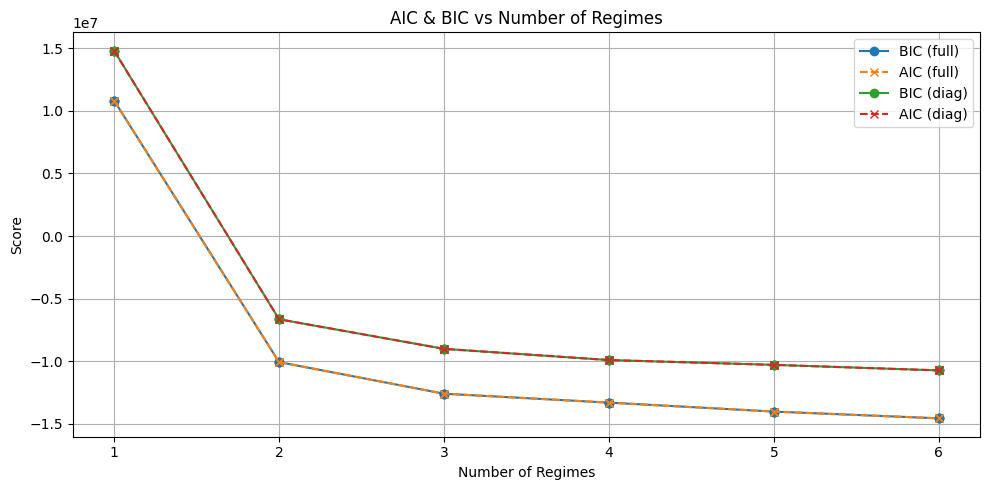

In [10]:
# Define parameter search space
n_obs, n_features = X.shape
n_components_range = range(1, 7)  # Number of regimes to test
covariance_types = ['full', 'diag']  # Covariance matrix types
tolerances = [1e-2, 1e-4, 1e-6]  # Convergence tolerances

results = []

for n_components, cov_type, tol in product(n_components_range, covariance_types, tolerances):
    try:
        model = GaussianHMM(
            n_components=n_components,
            covariance_type=cov_type,
            tol=tol,
            n_iter=1000,
            random_state=42
        )
        model.fit(X)
        logL = model.score(X)

        # Estimate number of parameters
        k = n_components * (n_components - 1)  # transition probs
        k += n_components - 1                 # initial probs
        k += n_components * n_features * 2    # means and variances

        bic = -2 * logL + k * np.log(n_obs)
        aic = -2 * logL + 2 * k

        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': logL,
            'AIC': aic,
            'BIC': bic
        })
    except Exception as e:
        results.append({
            'n_components': n_components,
            'cov_type': cov_type,
            'tol': tol,
            'log_likelihood': None,
            'AIC': np.inf,
            'BIC': np.inf,
            'error': str(e)
        })

# Convert to DataFrame and find best config
df_results = pd.DataFrame(results)
best_model = df_results.loc[df_results['BIC'].idxmin()]
print("Best Config (Based on BIC):")
print(best_model[["n_components", "cov_type", "tol", "BIC"]])

# Visualize BIC and AIC
plt.figure(figsize=(10, 5))
for cov in covariance_types:
    subset = df_results[df_results["cov_type"] == cov]
    plt.plot(subset["n_components"], subset["BIC"], label=f"BIC ({cov})", marker="o")
    plt.plot(subset["n_components"], subset["AIC"], label=f"AIC ({cov})", linestyle="--", marker="x")

plt.title("AIC & BIC vs Number of Regimes")
plt.xlabel("Number of Regimes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
X

array([[-0.52354507, -0.03980026,  0.01525454, ..., -0.09843118,
        -0.51390616, -1.10372916],
       [ 1.09799886, -0.03977666,  0.01526675, ...,  0.42089944,
        -0.00452263, -0.59312497],
       [ 1.09799886, -0.03977654,  0.01526616, ...,  0.35232442,
        -0.00452263, -0.584708  ],
       ...,
       [-0.59967519, -0.03403022,  0.01458107, ..., -0.48398538,
         0.42848192, -1.02073566],
       [-0.55210753, -0.03904844,  0.0150899 , ..., -0.15325467,
         0.63434703, -1.31771951],
       [-1.05711689, -0.03466425,  0.01385864, ..., -0.7130409 ,
         0.16900348, -1.22041724]])

In [12]:
best_model

n_components                    6
cov_type                     full
tol                      0.000001
log_likelihood     7290559.022158
AIC              -14580832.044317
BIC              -14579220.294929
Name: 32, dtype: object

Model is not converging.  Current: 7290559.048695166 is not greater than 7290559.079220695. Delta is -0.030525529757142067


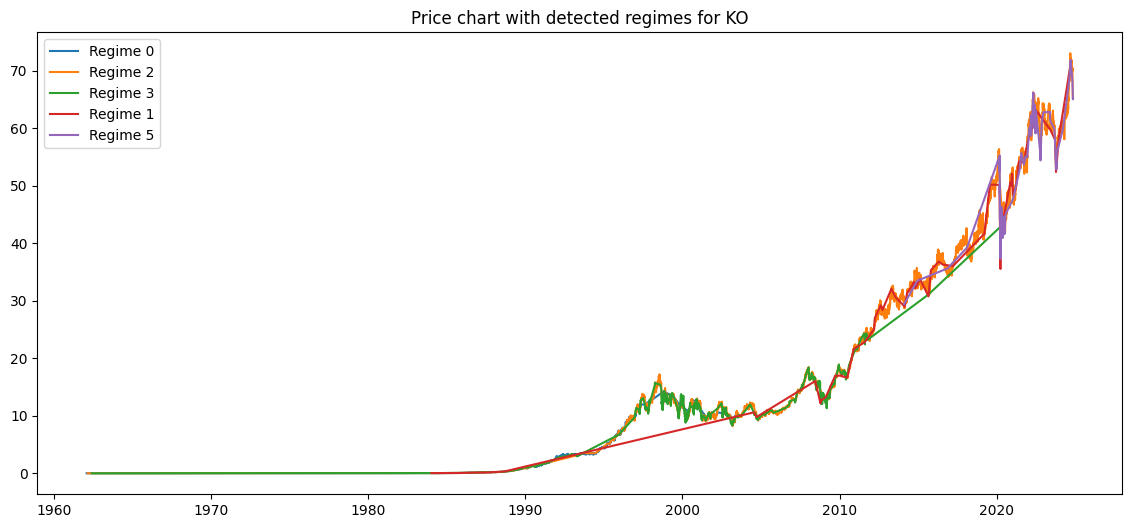

In [13]:
best_params = best_model

gaussian_model = GaussianHMM(
    n_components=int(best_params['n_components']),
    covariance_type=best_params['cov_type'],
    tol=best_params['tol'],
    n_iter=1000,
    random_state=42
)
gaussian_model.fit(X)

# Predict the hidden regime for each row
gauss_states = gaussian_model.predict(X)

df_regime = df_features.dropna(subset=["rsi_scaled", "macd_scaled", "atr_scaled"]).copy()
df_regime["regime"] = gauss_states

sample_ticker = df_regime["Ticker"].iloc[0]  # use any ticker
sample_df = df_regime[df_regime["Ticker"] == sample_ticker]

plt.figure(figsize=(14, 6))
for state in sample_df["regime"].unique():
    subset = sample_df[sample_df["regime"] == state]
    plt.plot(subset["Date"], subset["Close"], label=f"Regime {state}")
plt.legend()
plt.title(f"Price chart with detected regimes for {sample_ticker}")
plt.show()

Assumption Checks

1. Stationarity
2. Normality
3. Independence

In [14]:
def hmm_assumption_diagnostics(df_regime, features, regime_col="regime", date_col="Date", plot=False):
    """
    Tests HMM assumptions (Stationarity, Normality, Independence) for each feature in each regime.

    Parameters:
        df_regime (pd.DataFrame): DataFrame with features and regime labels.
        features (list): List of feature column names.
        regime_col (str): Column name for regimes.
        date_col (str): Date column for plotting.
        plot (bool): Whether to show rolling mean/std, Q-Q, and ACF plots.
    
    Returns:
        pd.DataFrame: Summary of test results.
    """
    results = []

    for regime in sorted(df_regime[regime_col].unique()):
        regime_data = df_regime[df_regime[regime_col] == regime]
        
        for feature in features:
            series = regime_data[feature].dropna()
            if len(series) < 30:
                continue  # skip small samples

            # --- 1. Stationarity Test (ADF) ---
            try:
                adf_stat, adf_p, *_ = adfuller(series)
            except:
                adf_p = np.nan

            # --- 2. Normality Test (Shapiro-Wilk) ---
            try:
                shapiro_stat, shapiro_p = shapiro(series.sample(min(5000, len(series))))
            except:
                shapiro_p = np.nan

            # --- 3. Independence Test (Ljung-Box) ---
            try:
                lb_test = acorr_ljungbox(series, lags=[10], return_df=True)
                lb_p = lb_test['lb_pvalue'].iloc[0]
            except:
                lb_p = np.nan

            results.append({
                "Regime": regime,
                "Feature": feature,
                "ADF_p (Stationarity)": adf_p,
                "Shapiro_p (Normality)": shapiro_p,
                "LjungBox_p (Independence)": lb_p
            })

            # plotting
            if plot:
                fig, axes = plt.subplots(1, 3, figsize=(15, 4))
                fig.suptitle(f"{feature} - Regime {regime}", fontsize=12)

                # Rolling mean/std
                series.rolling(50).mean().plot(ax=axes[0], title="Rolling Mean")
                series.rolling(50).std().plot(ax=axes[1], title="Rolling Std")

                # Q-Q Plot
                sm.qqplot(series, line='s', ax=axes[2])
                axes[2].set_title("Q-Q Plot")
                plt.show()

                # ACF plot
                sm.graphics.tsa.plot_acf(series, lags=20)
                plt.title("Autocorrelation (ACF)")
                plt.show()

    results_df = pd.DataFrame(results)

    # Mark assumptions (Pass if p > 0.05)
    results_df["Stationary?"] = results_df["ADF_p (Stationarity)"] < 0.05
    results_df["Normal?"] = results_df["Shapiro_p (Normality)"] > 0.05
    results_df["Independent?"] = results_df["LjungBox_p (Independence)"] > 0.05

    return results_df

In [15]:
scaled_cols

['rsi_scaled',
 'sma20_scaled',
 'macd_scaled',
 'atr_scaled',
 'daily_return_scaled',
 'bb_percent_scaled',
 'price_to_sma_scaled',
 'co_ratio_scaled',
 'volume_z_scaled']

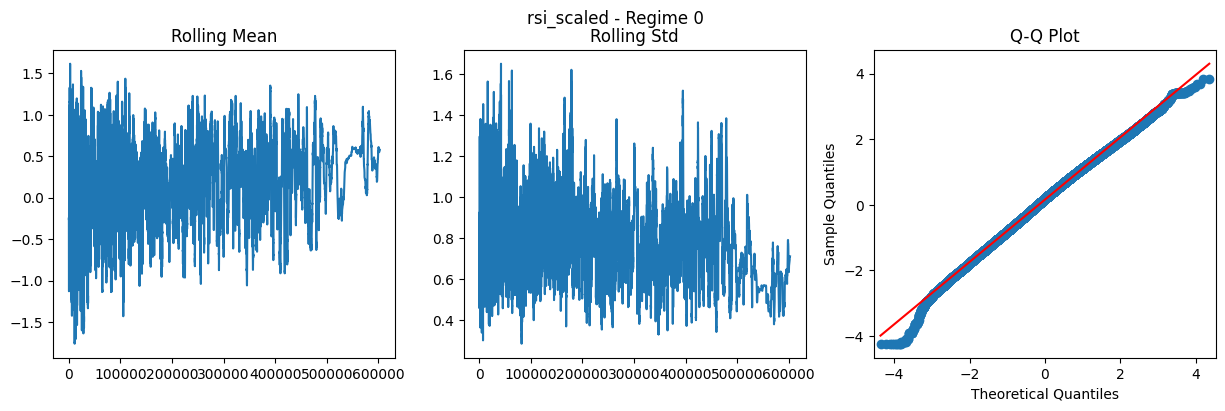

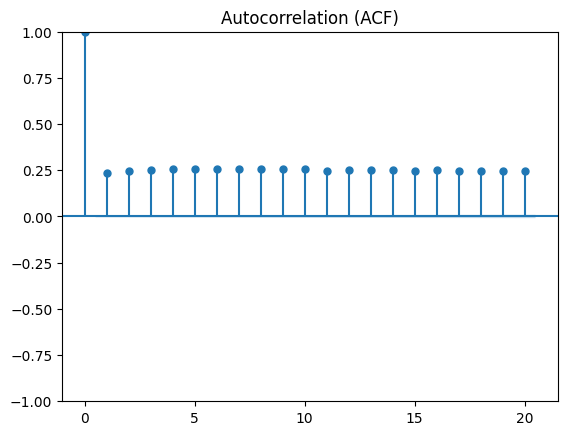

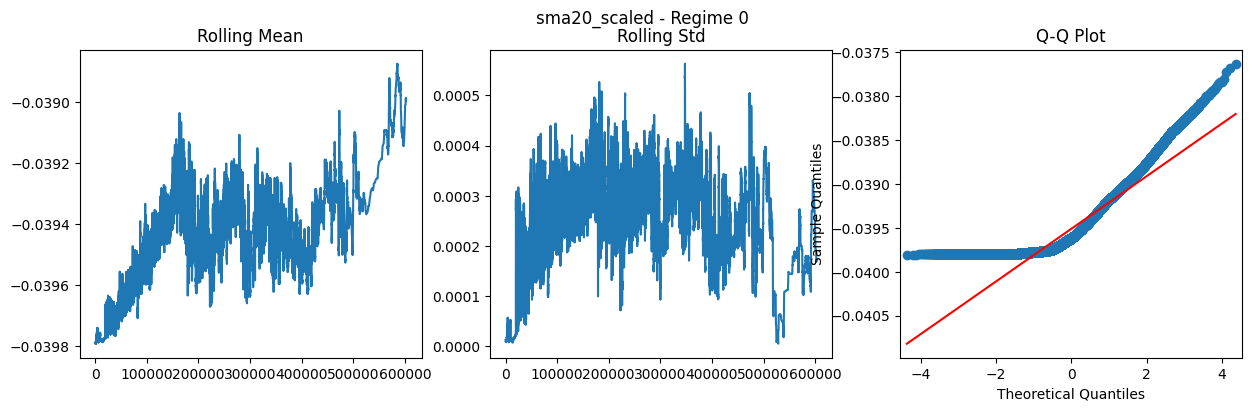

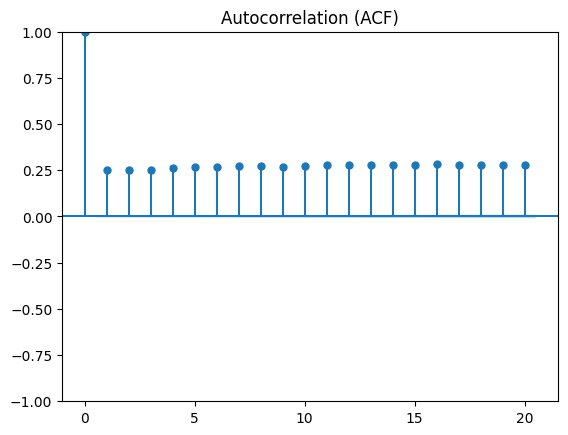

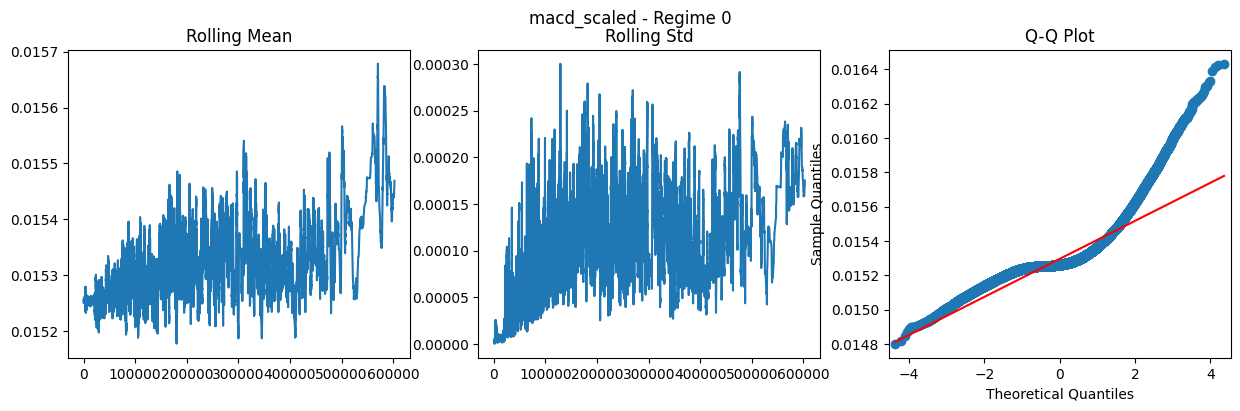

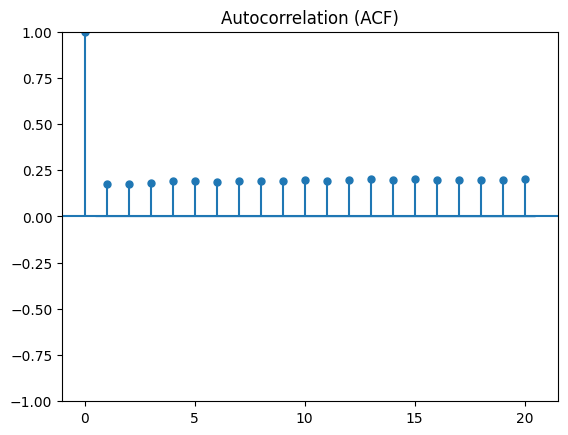

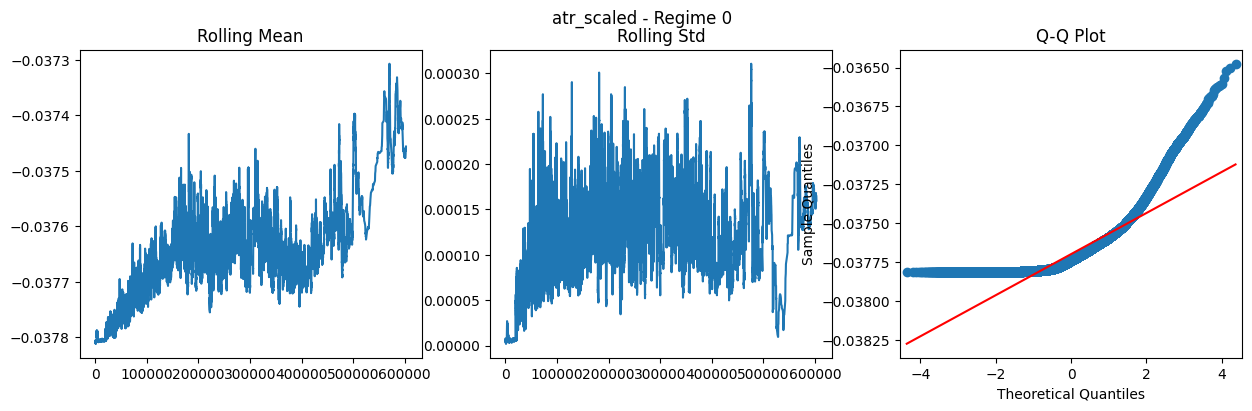

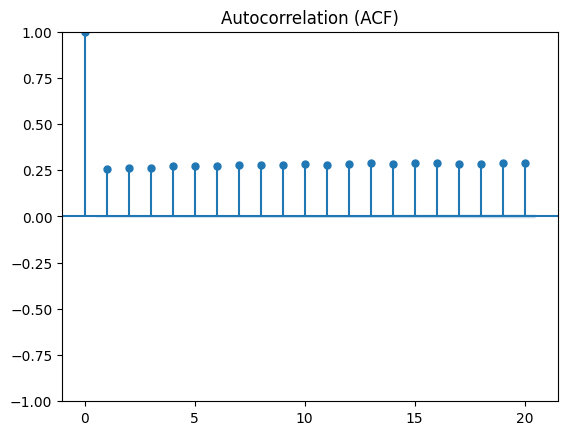

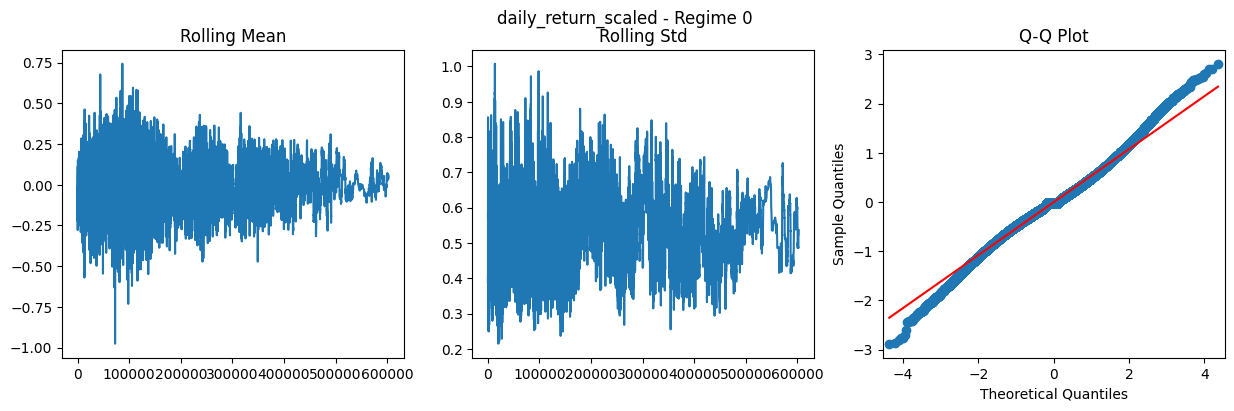

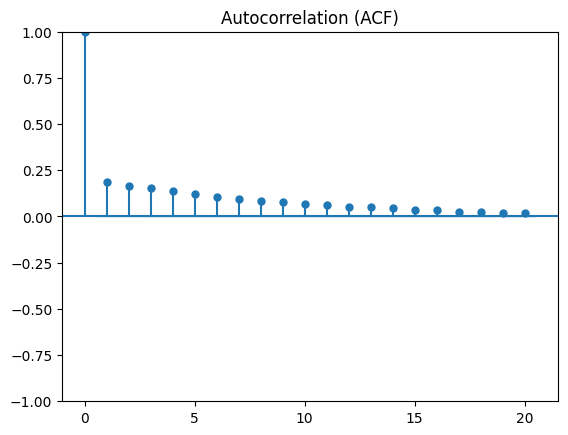

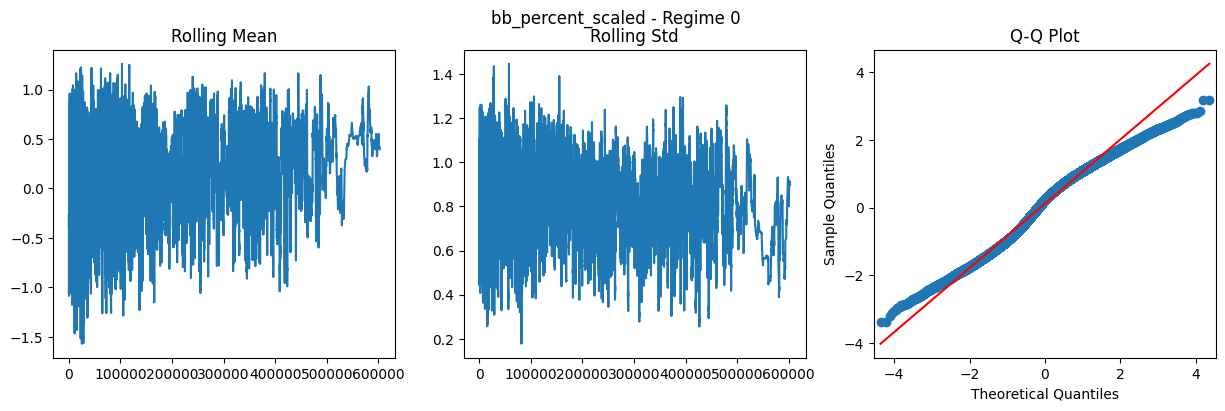

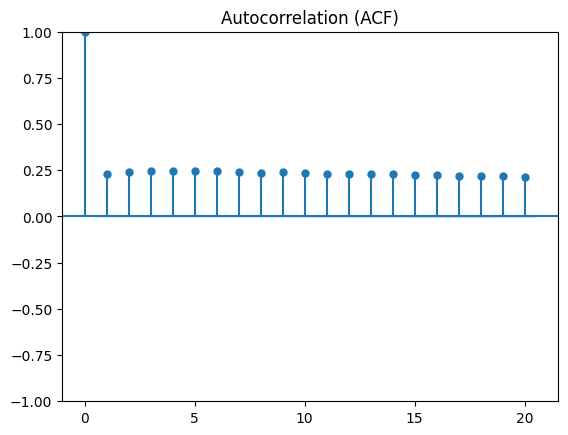

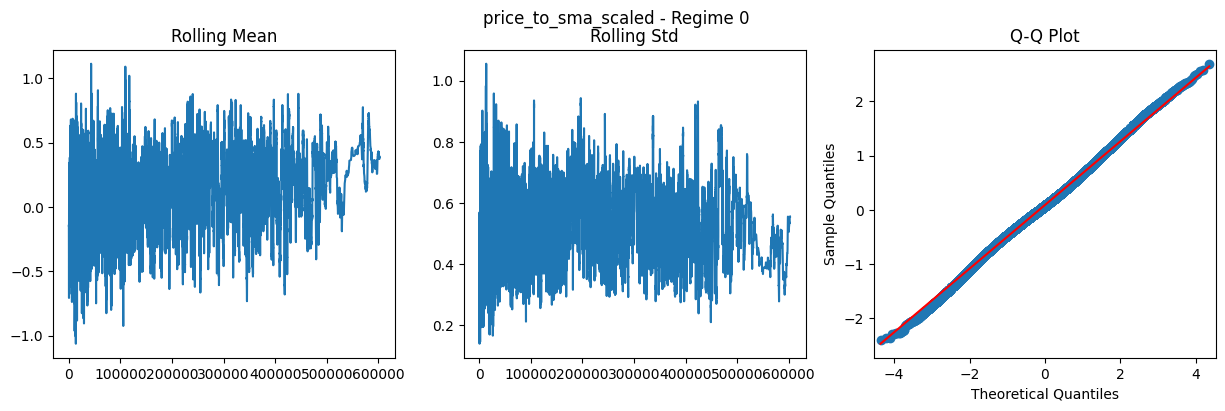

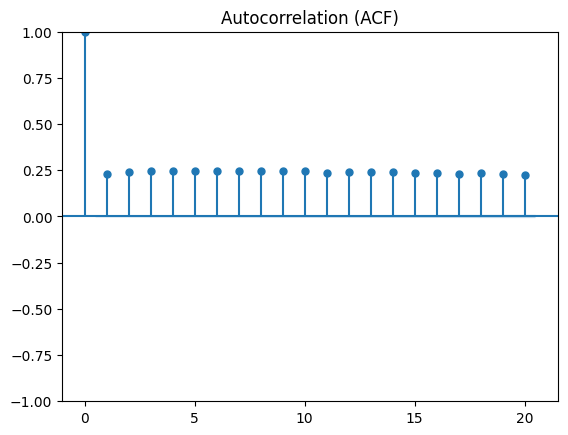

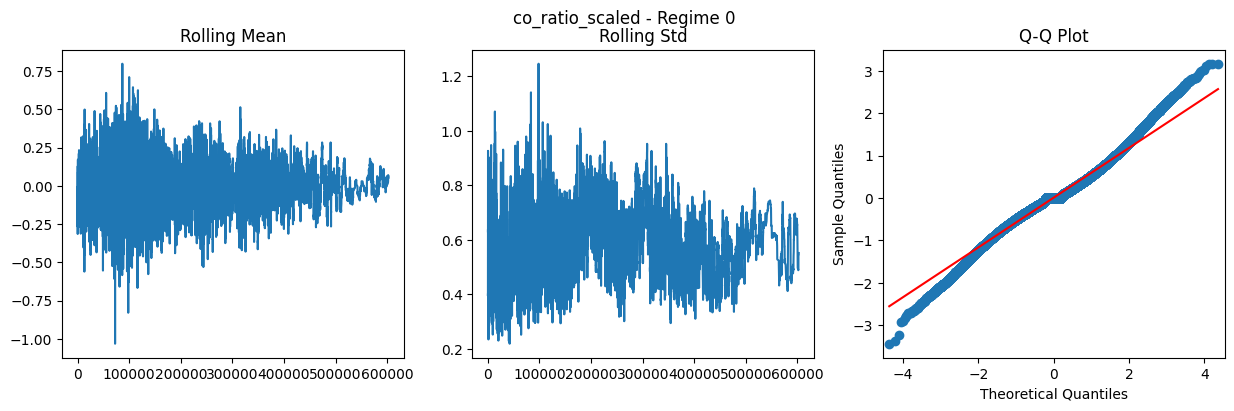

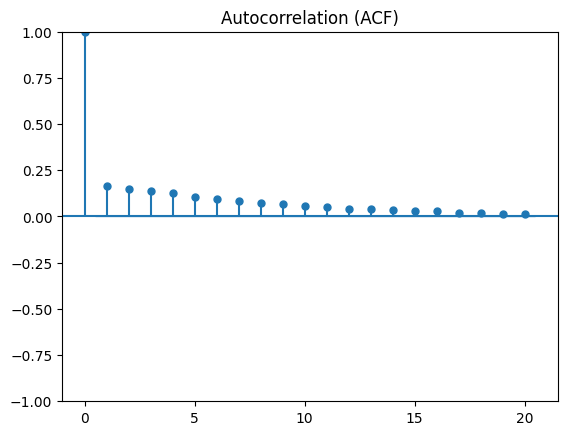

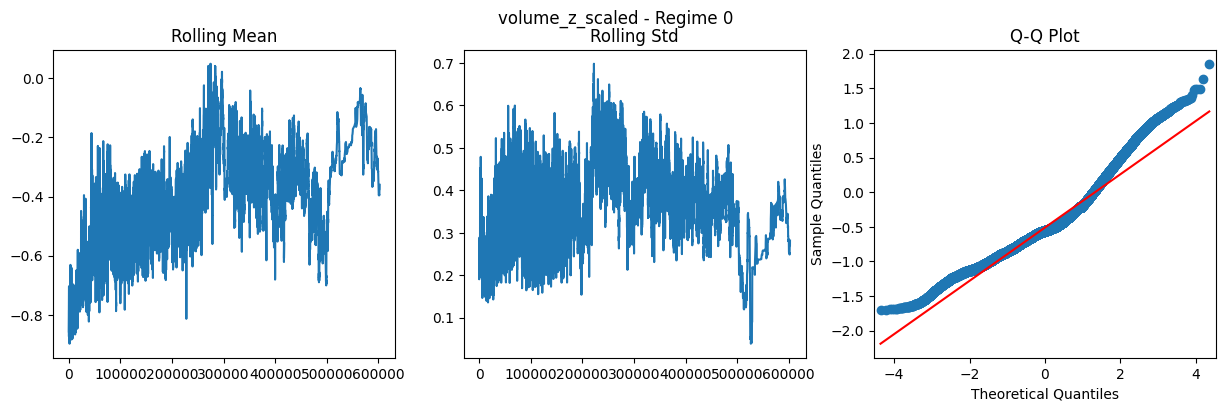

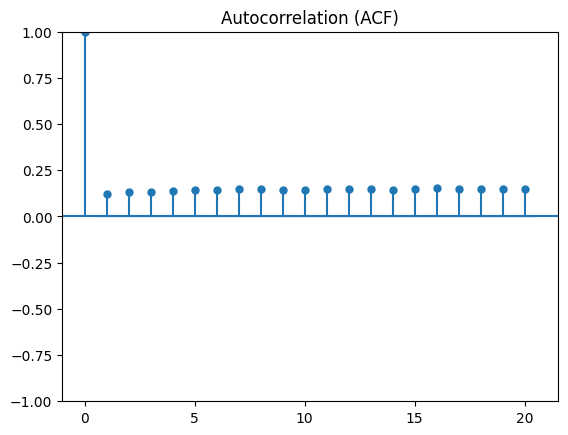

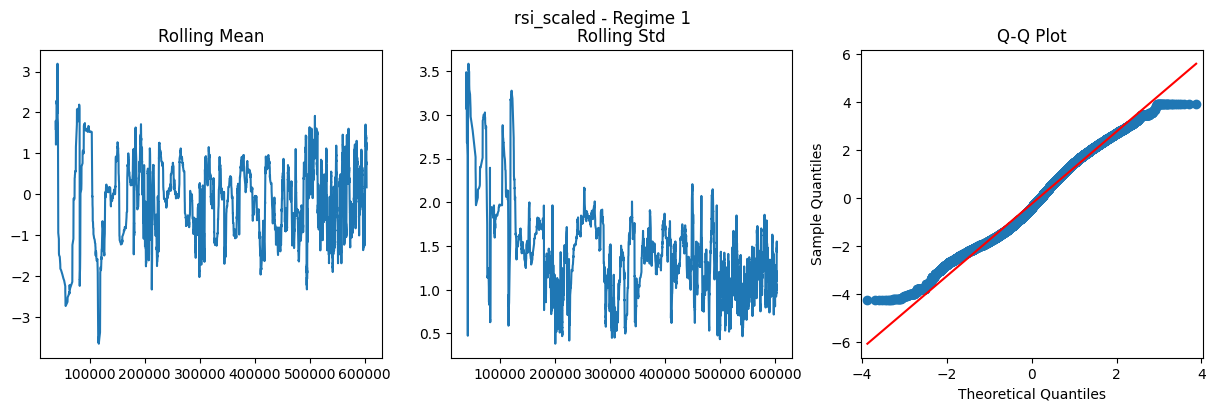

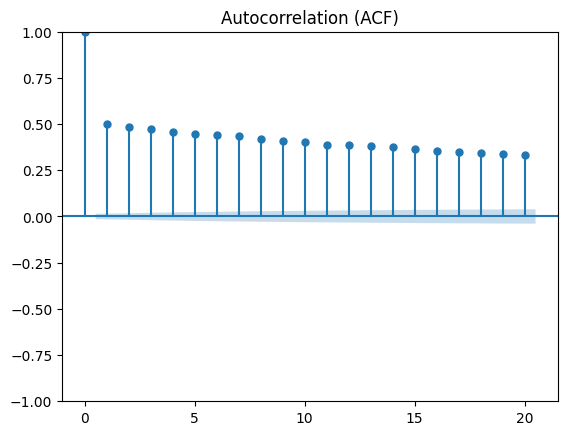

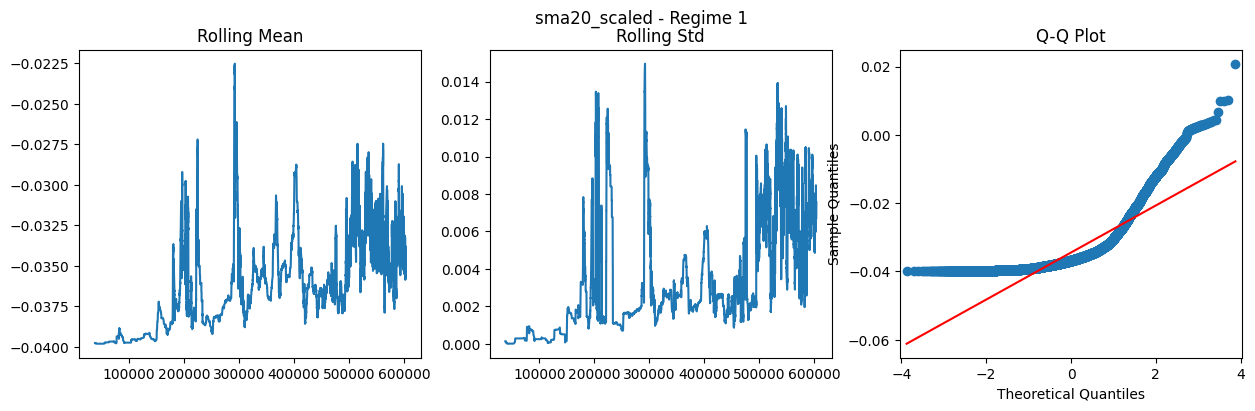

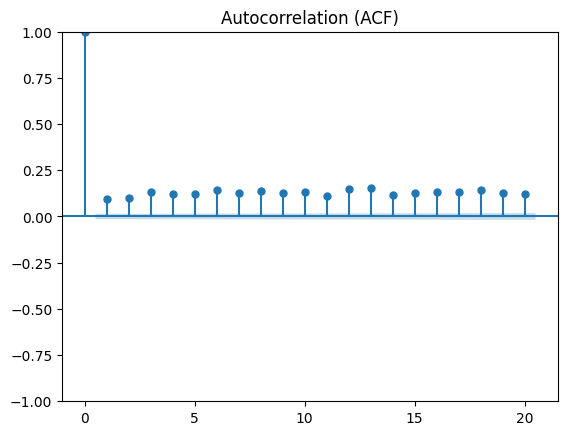

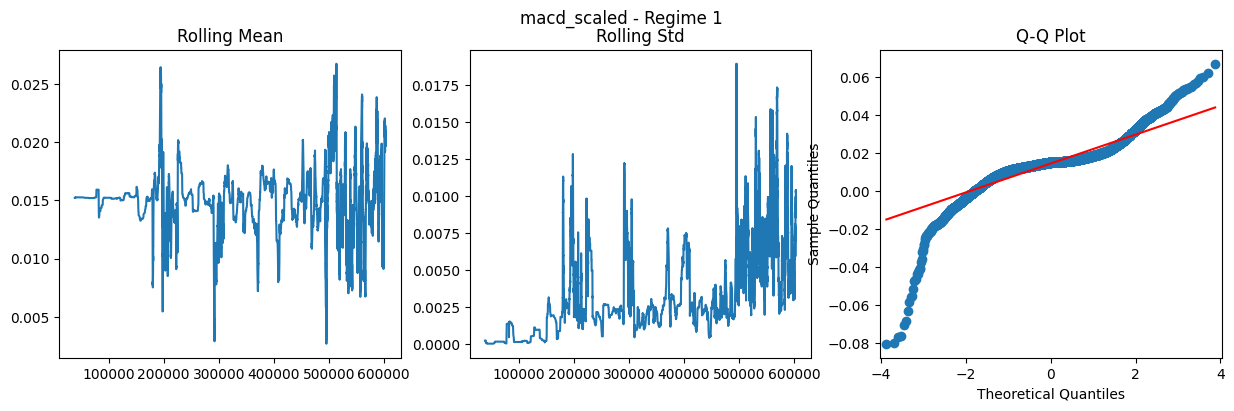

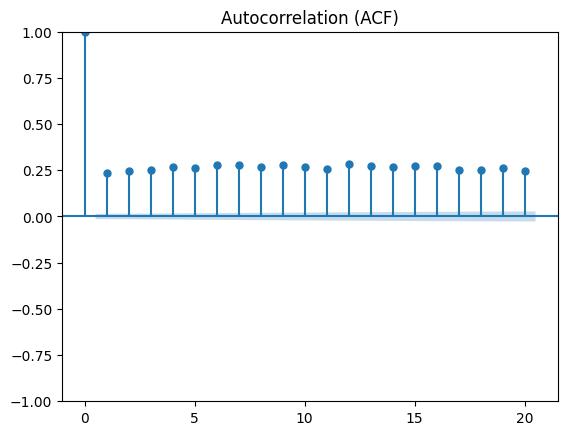

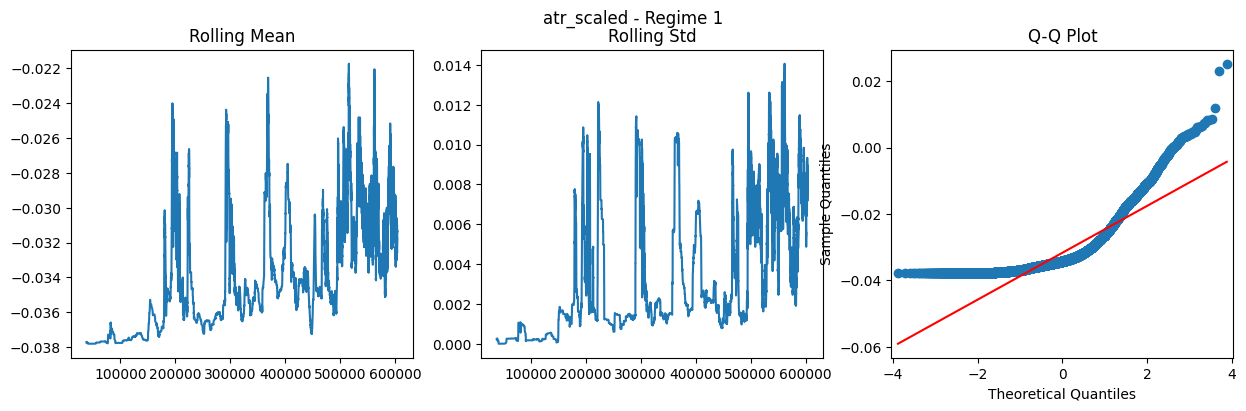

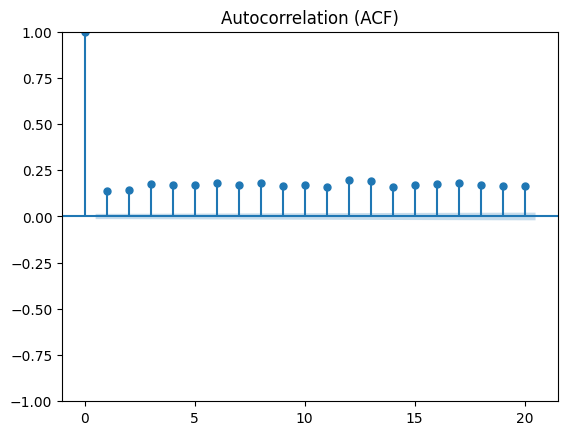

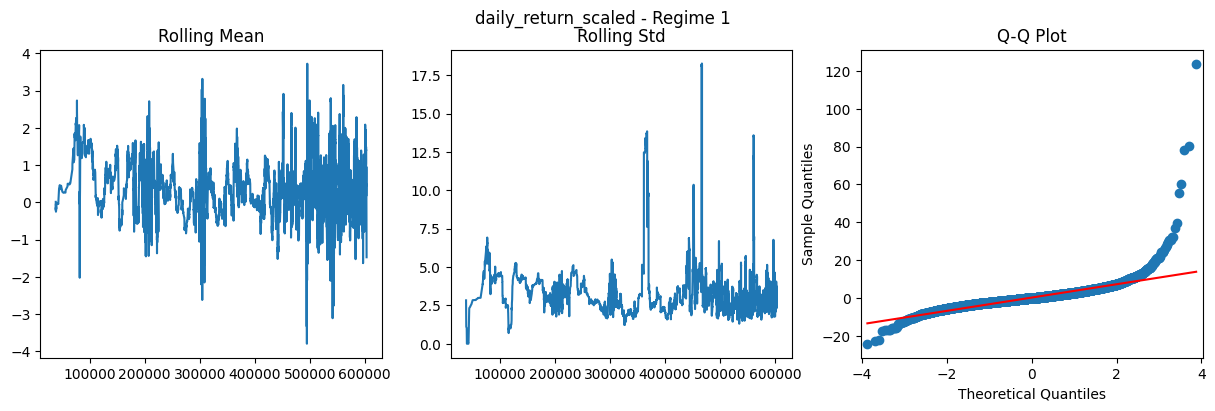

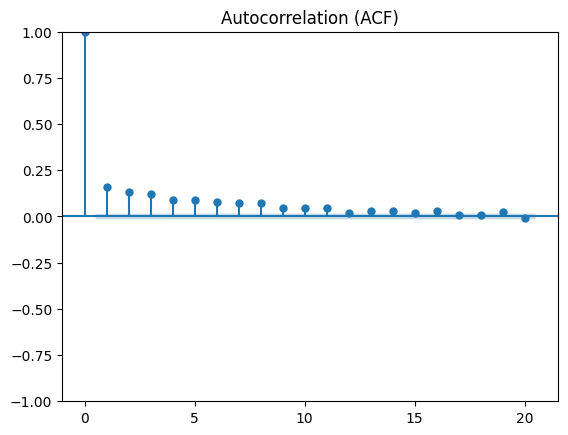

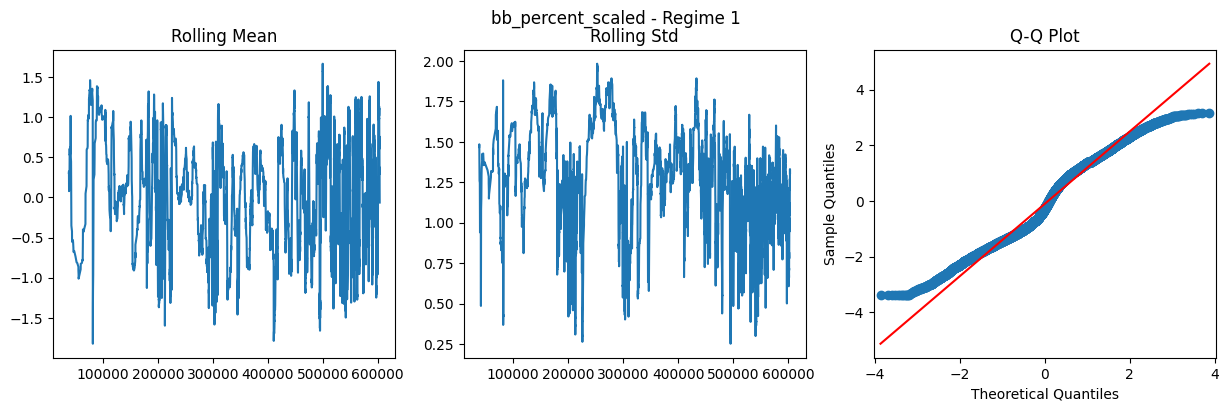

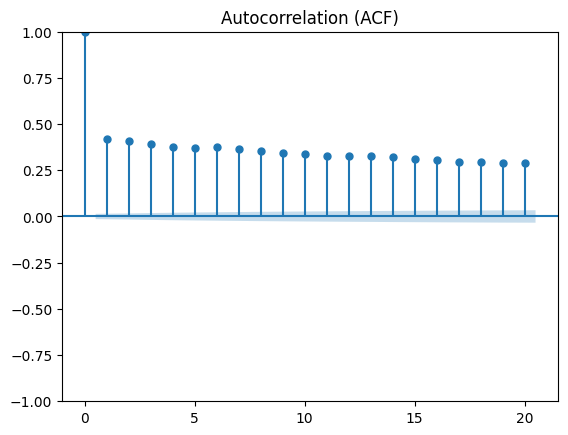

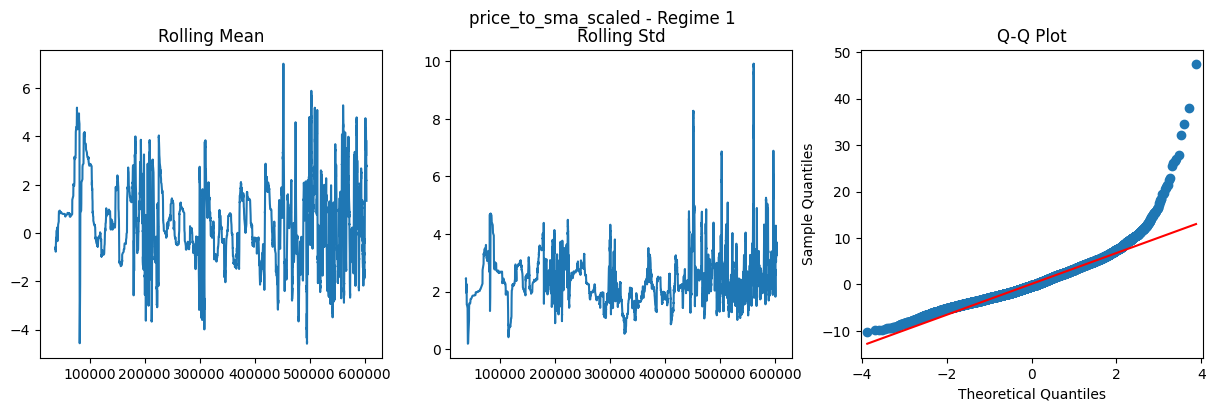

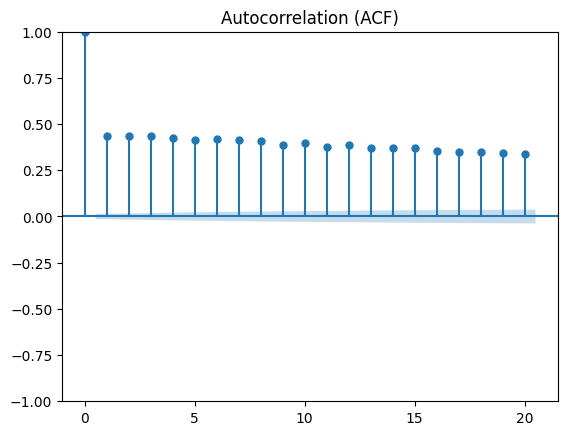

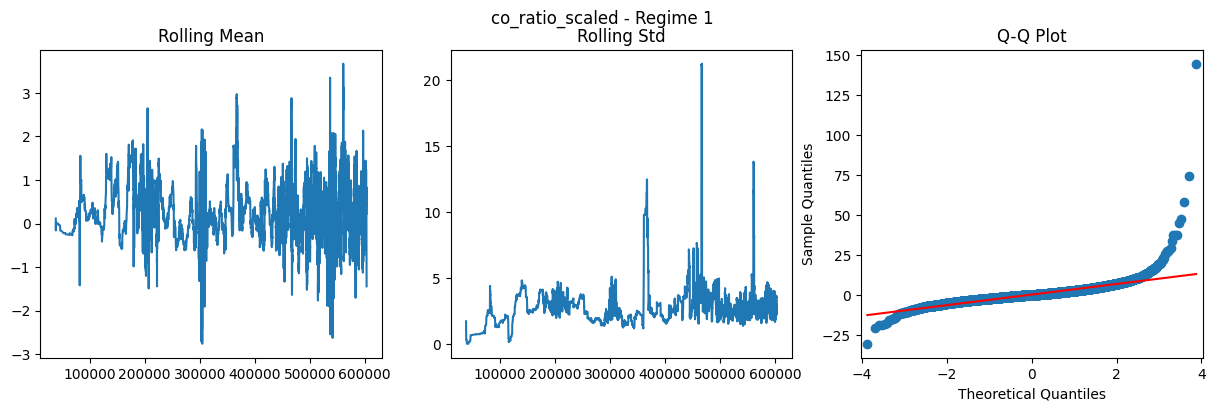

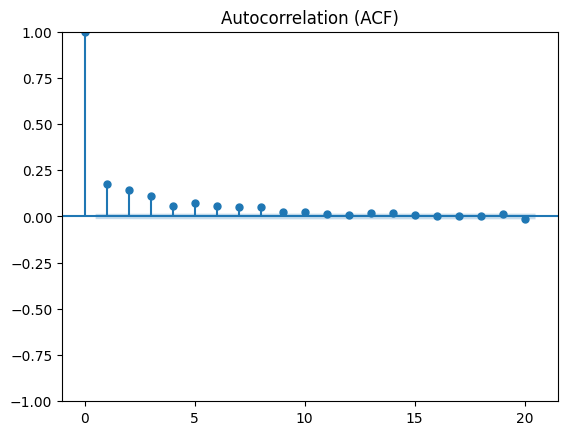

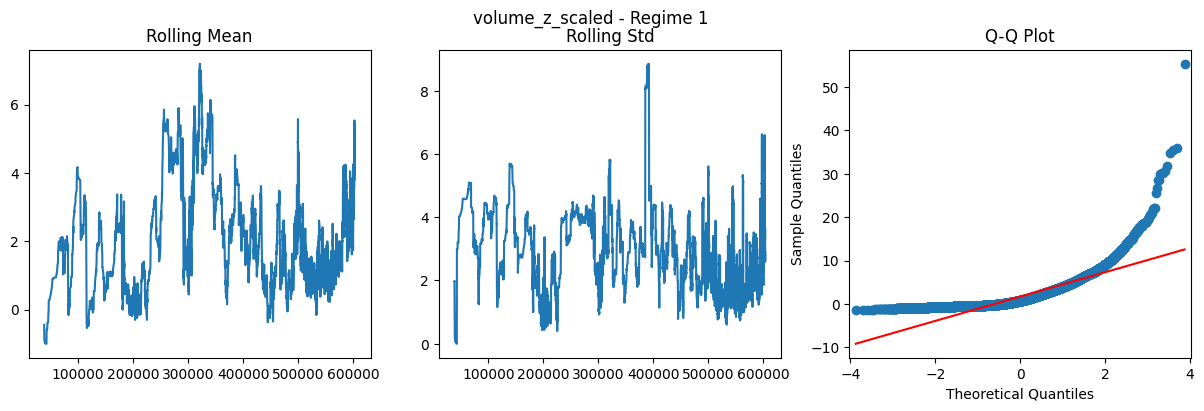

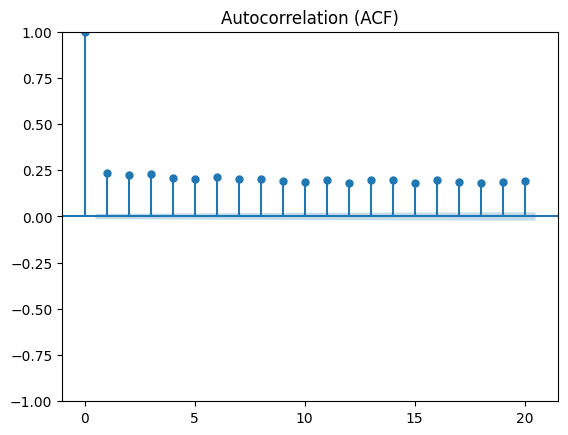

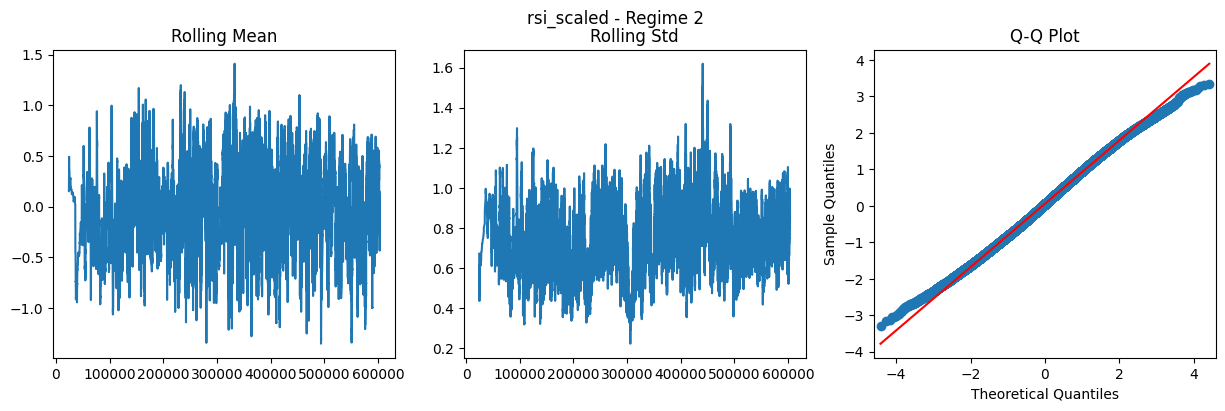

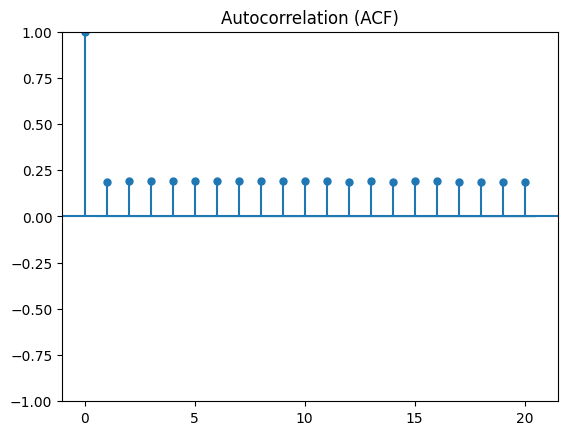

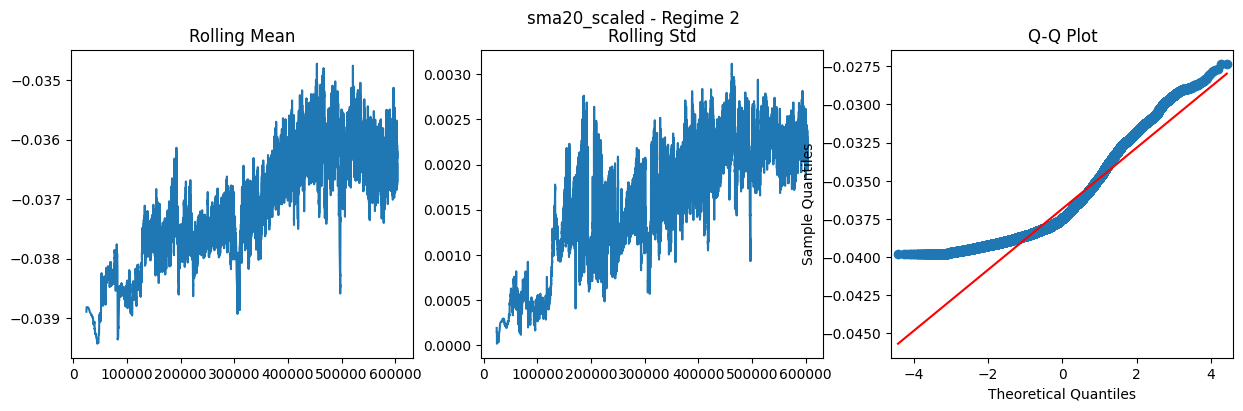

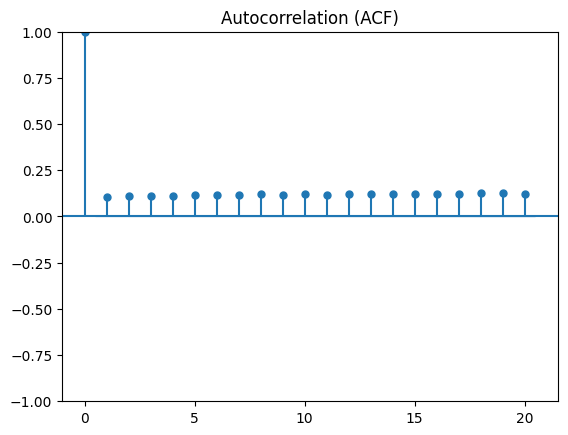

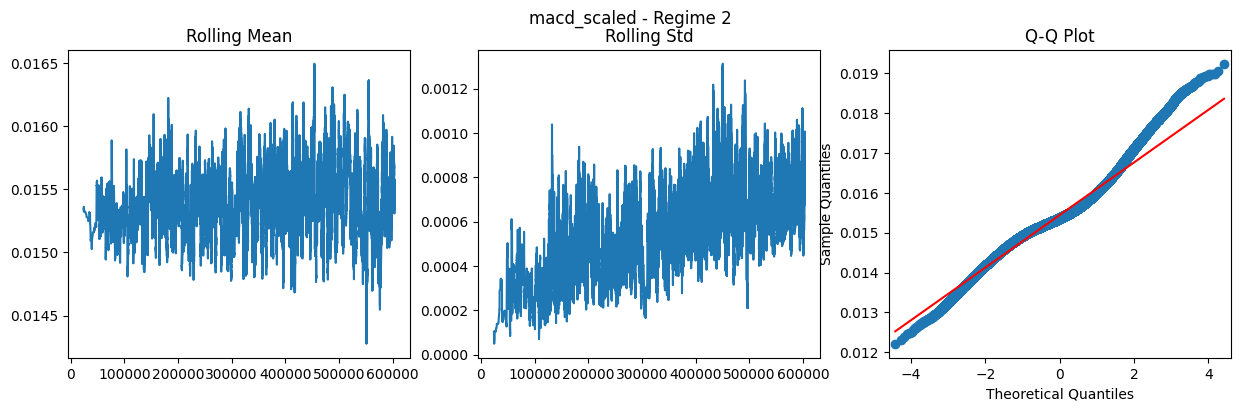

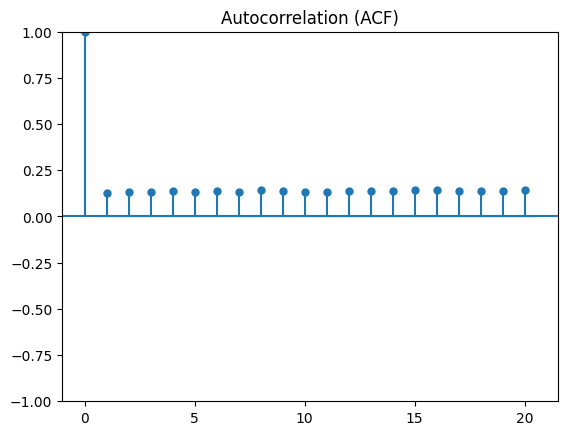

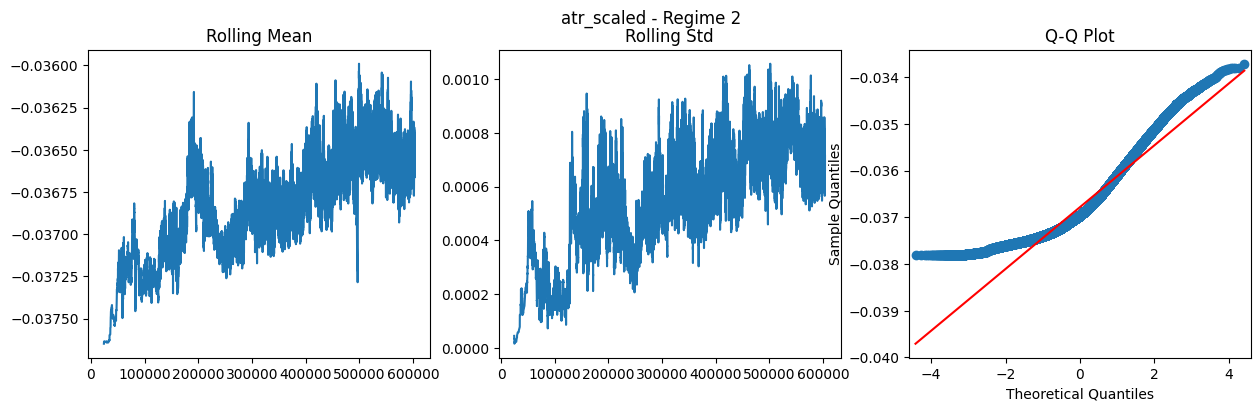

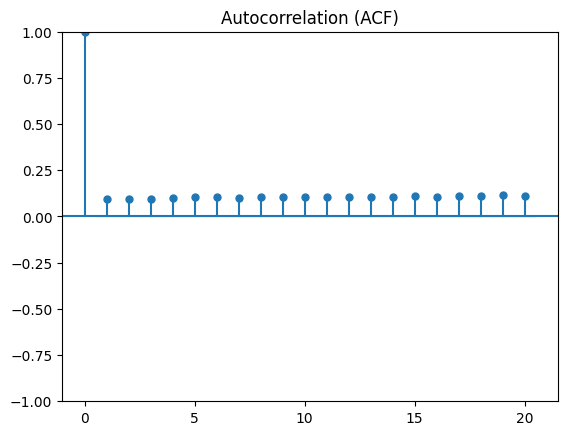

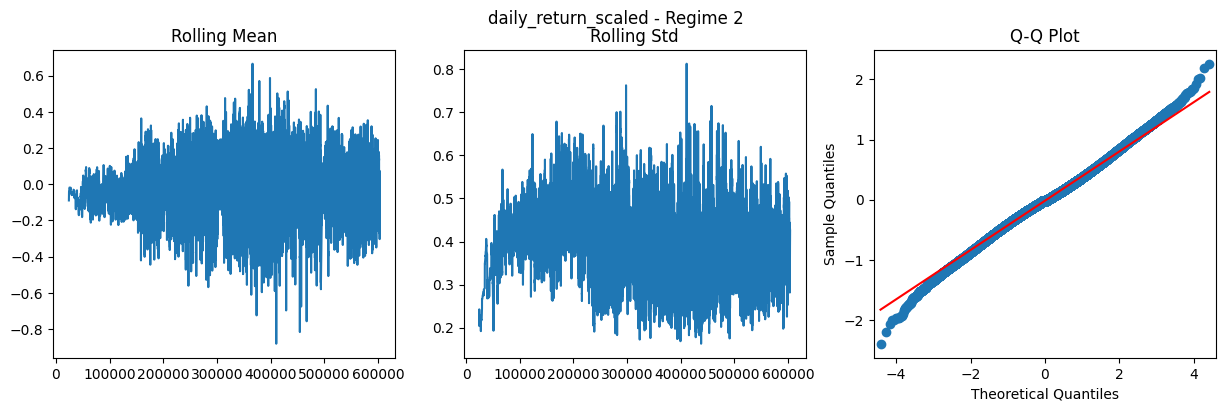

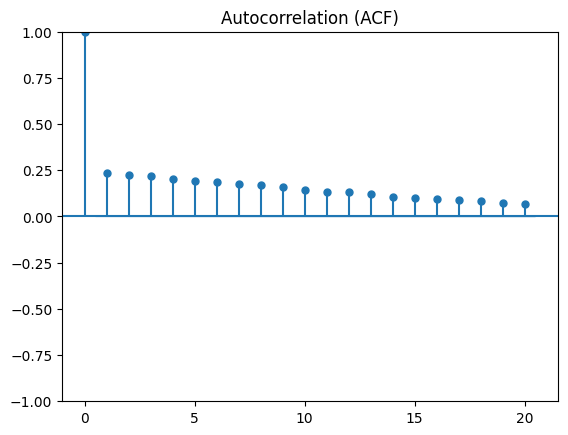

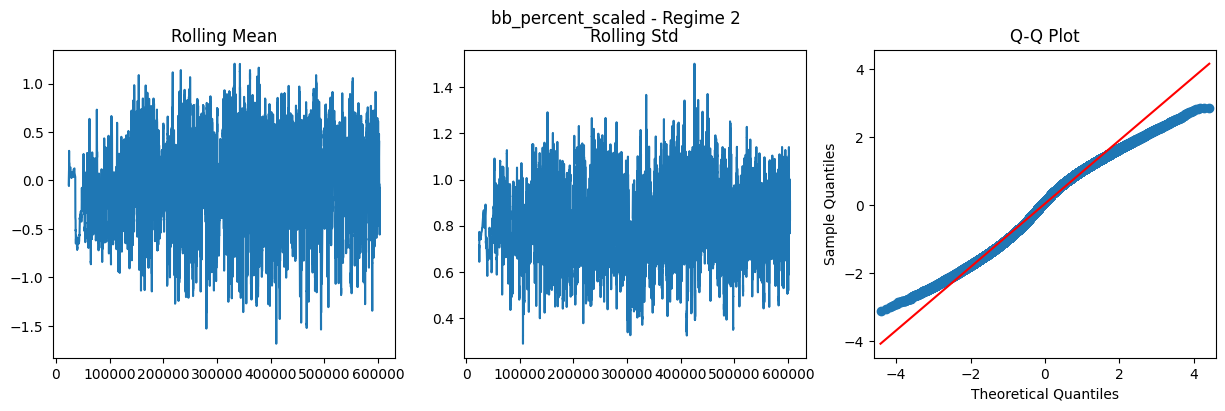

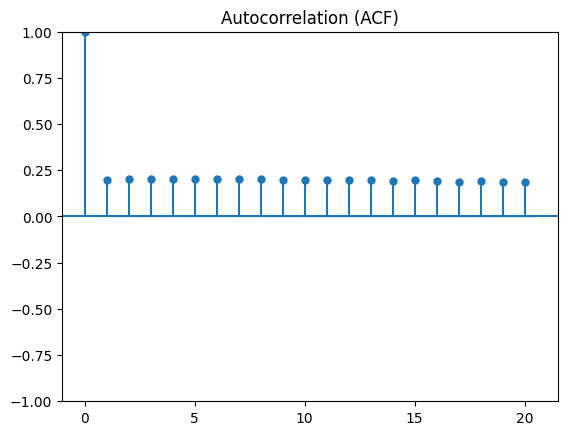

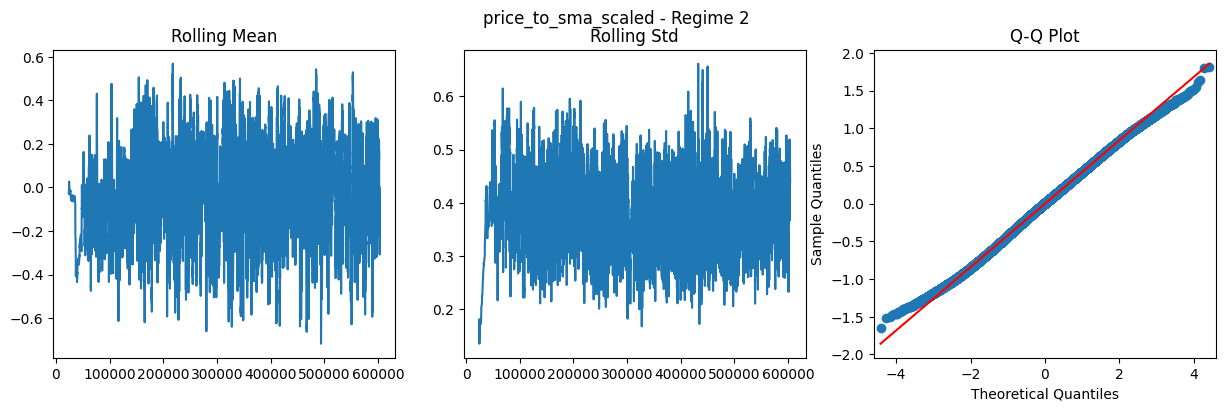

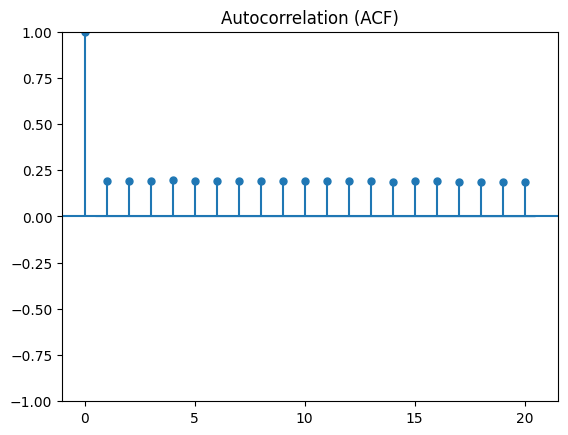

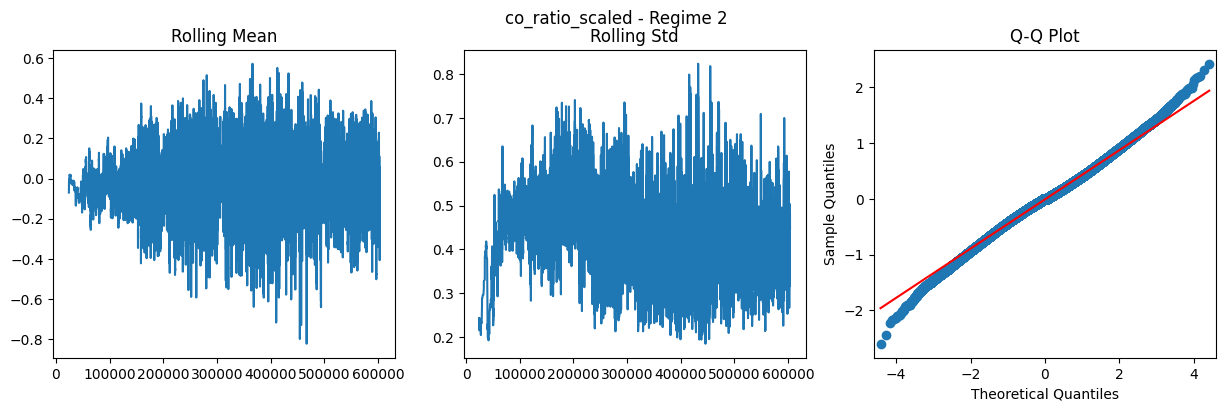

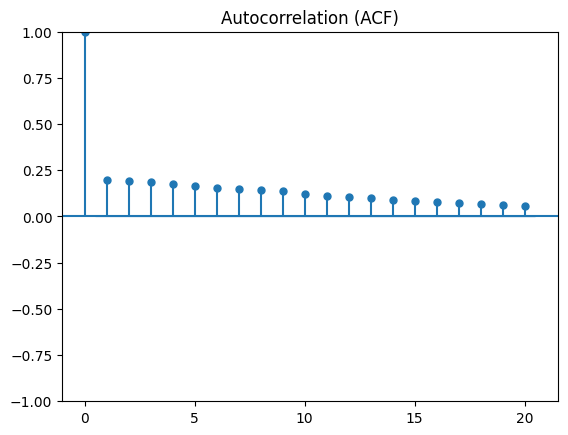

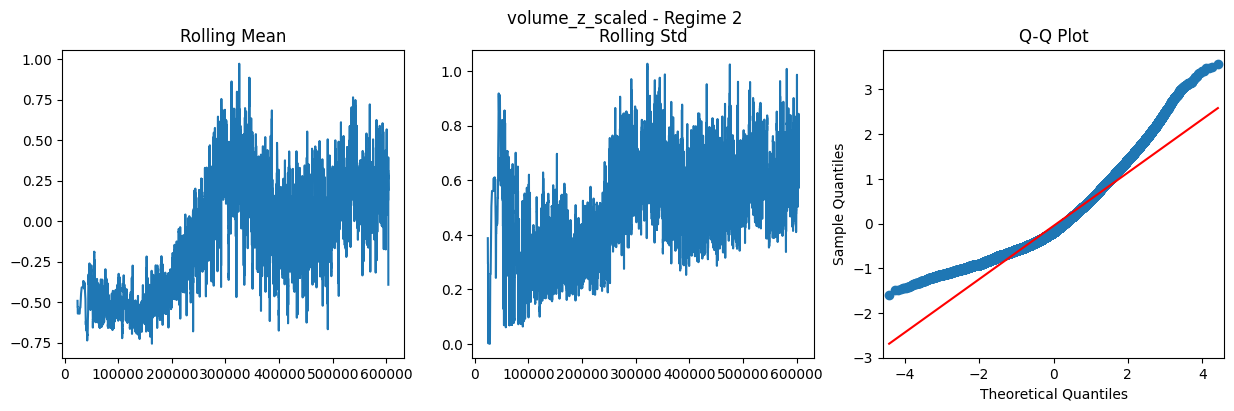

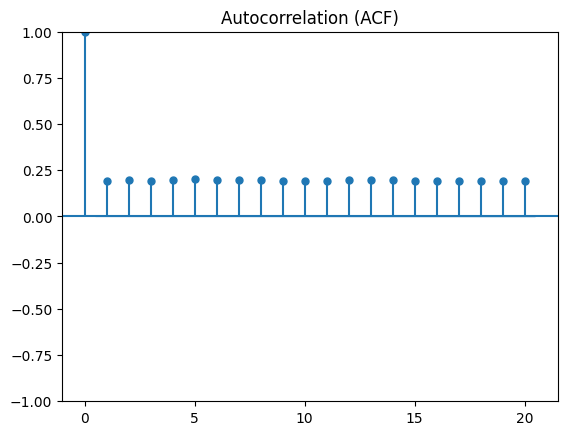

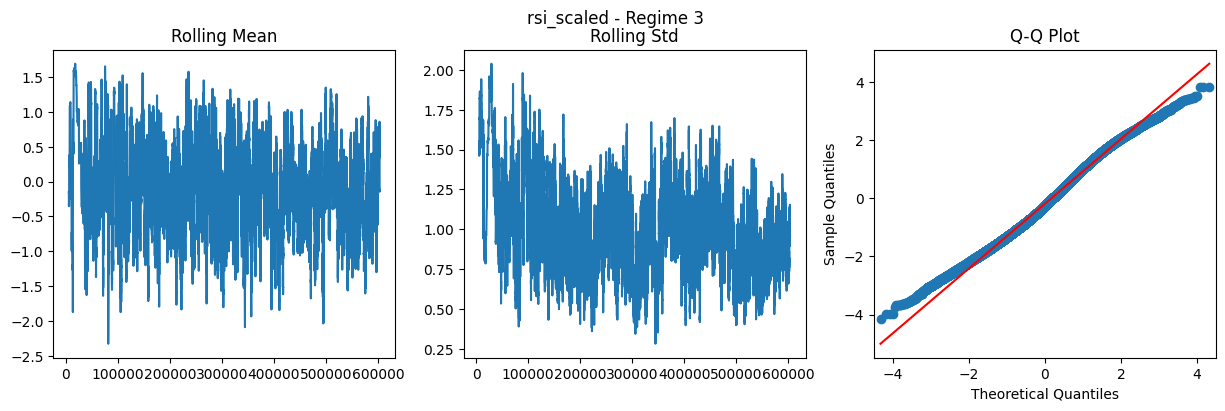

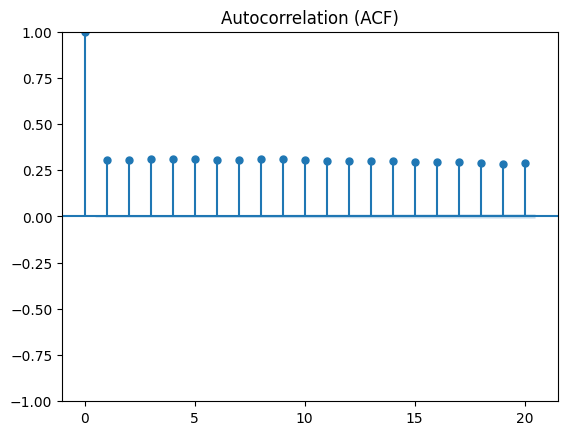

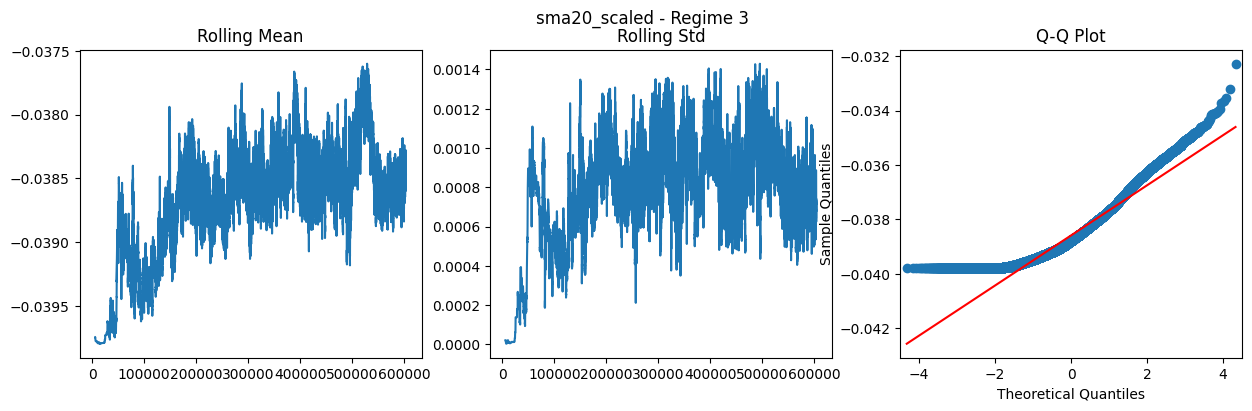

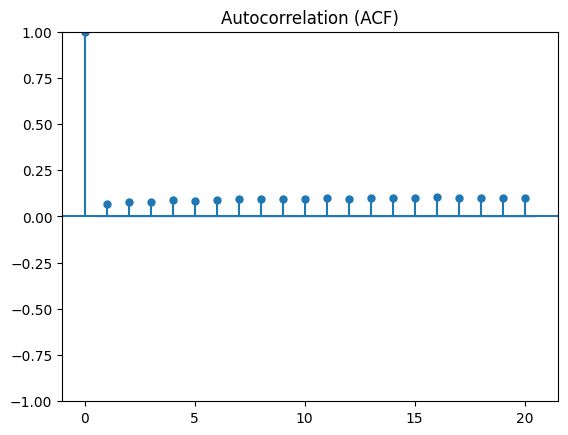

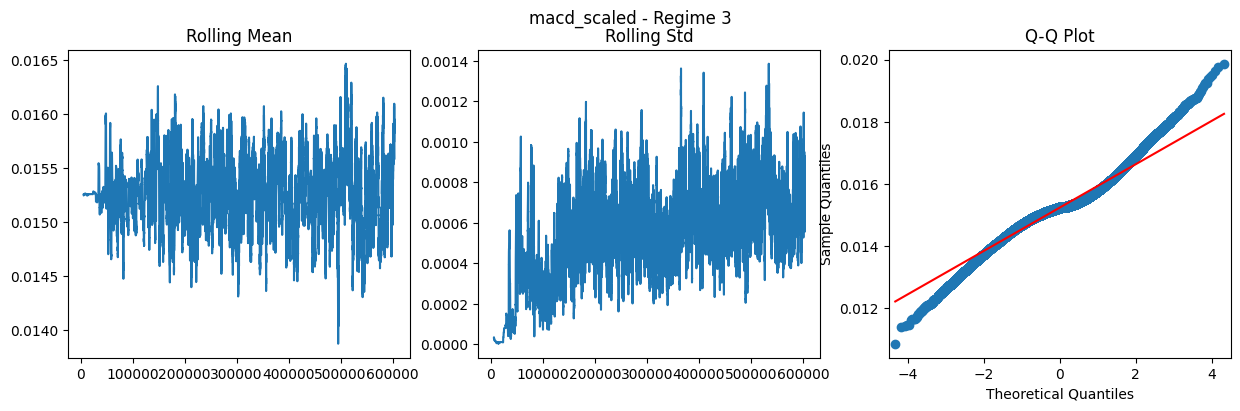

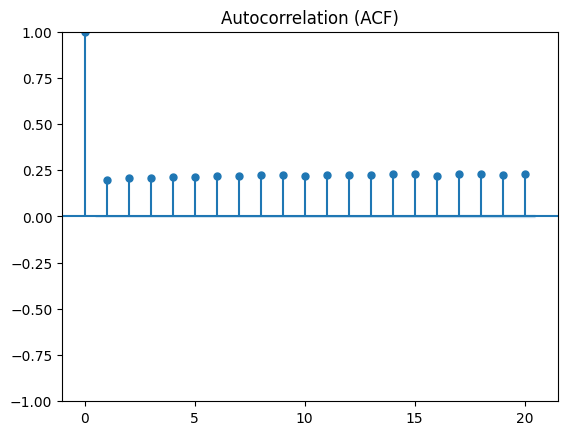

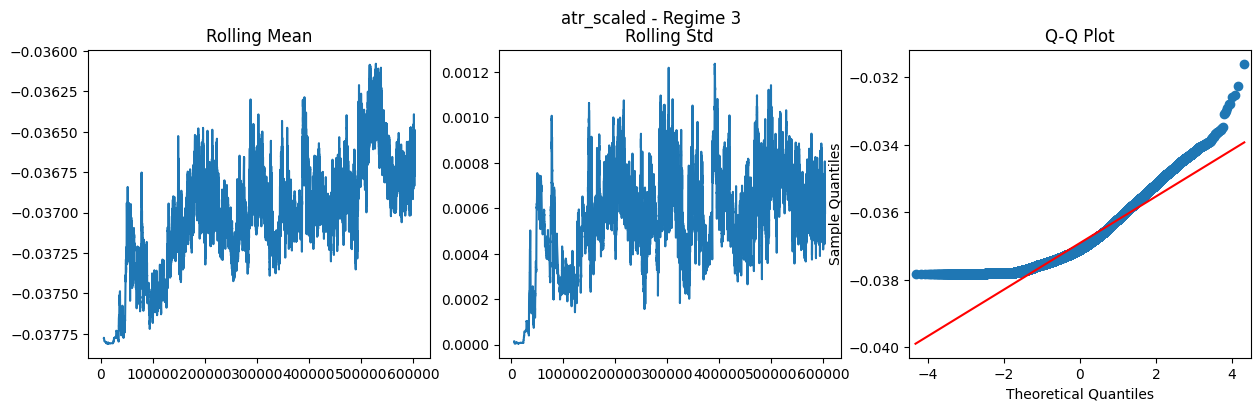

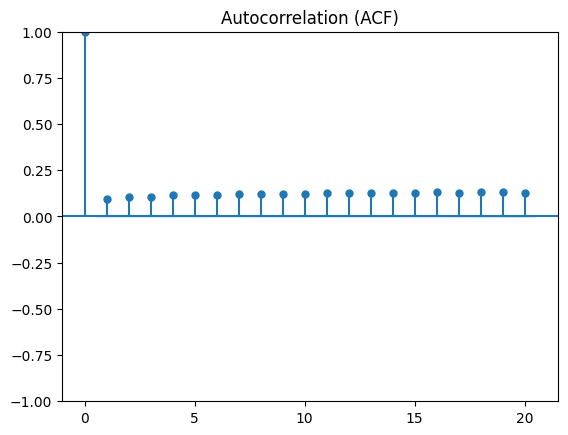

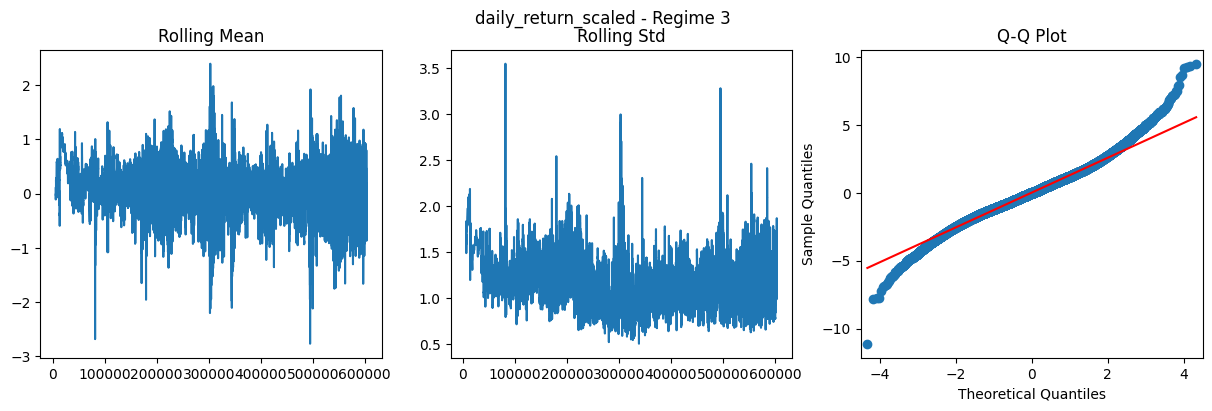

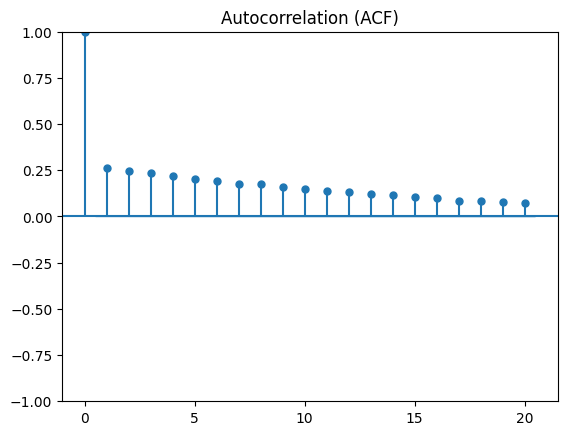

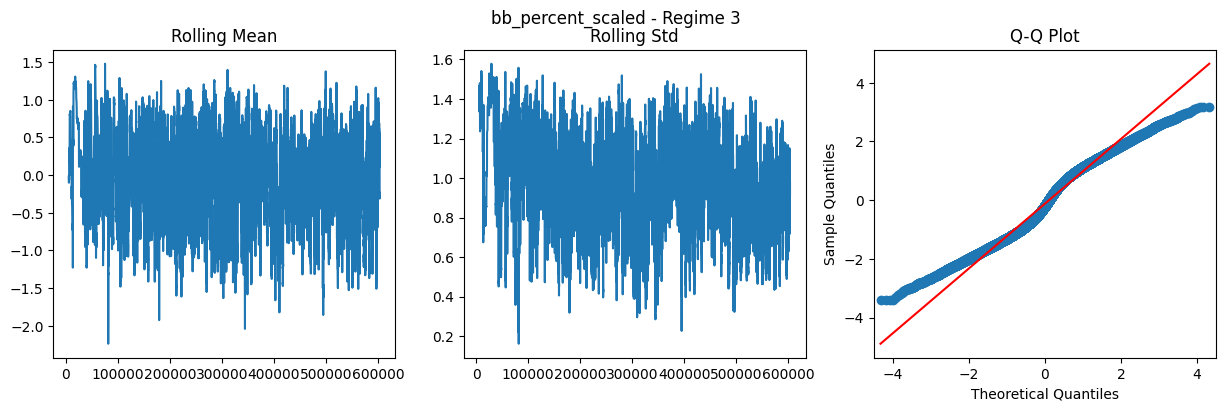

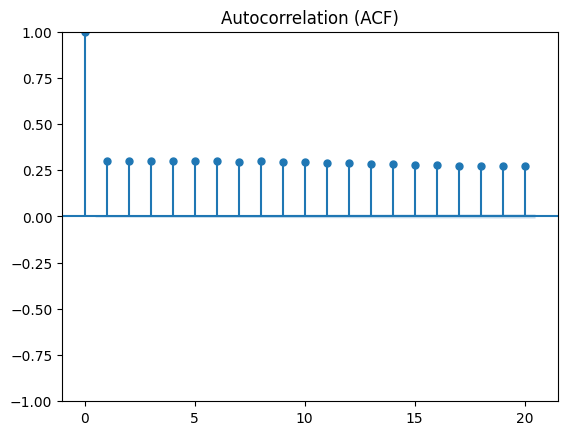

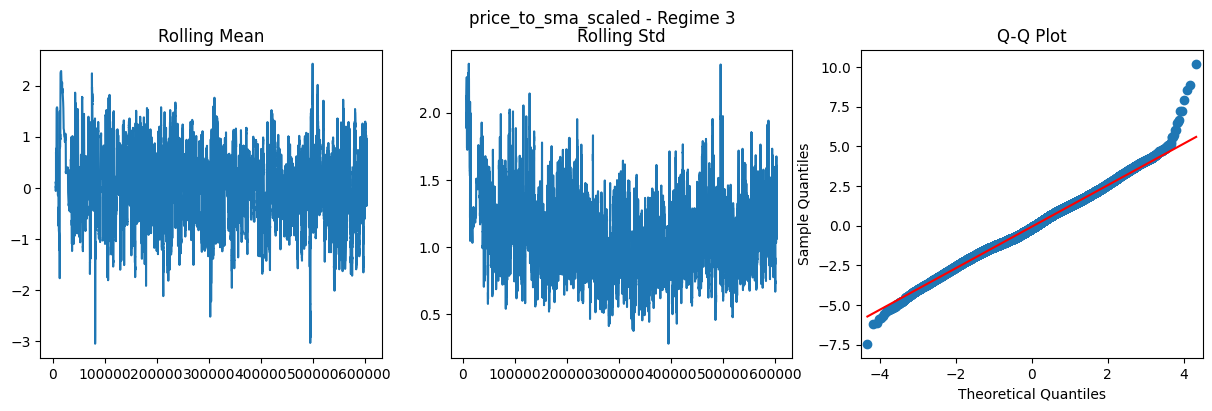

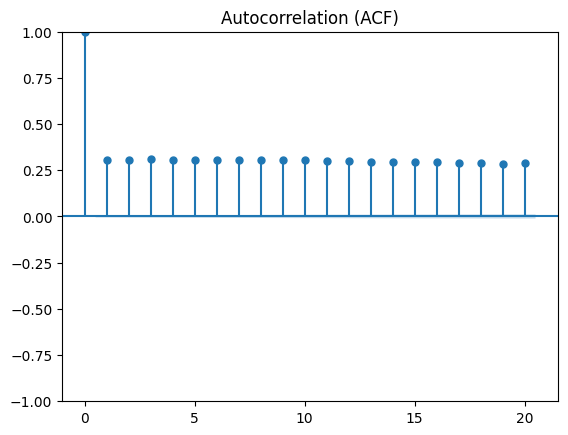

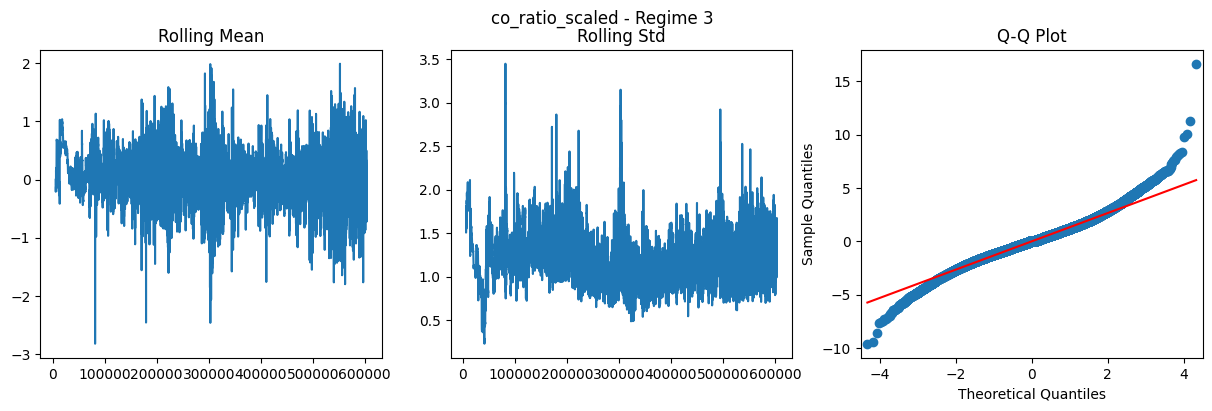

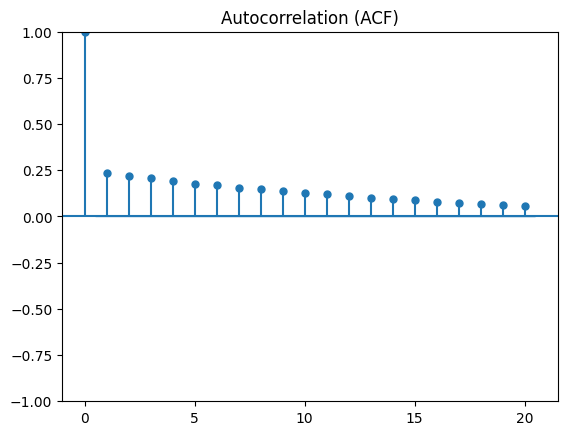

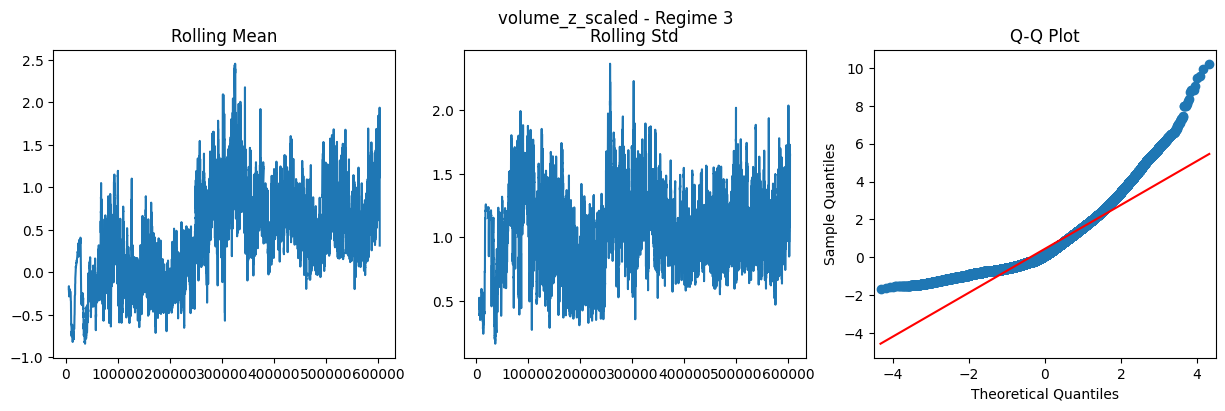

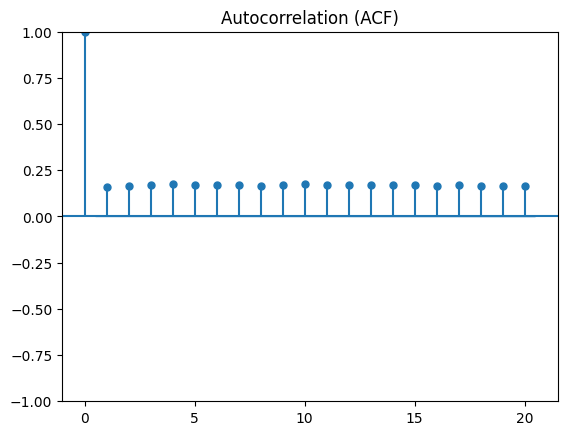

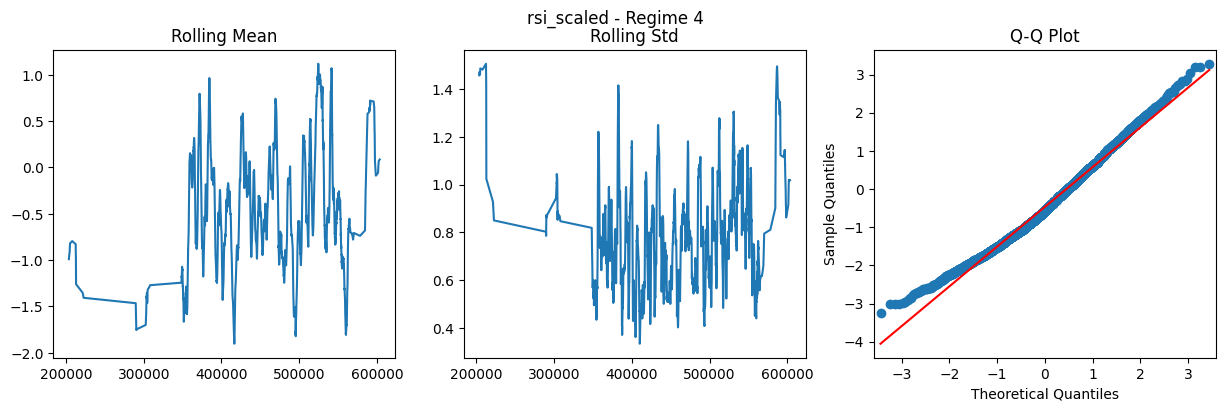

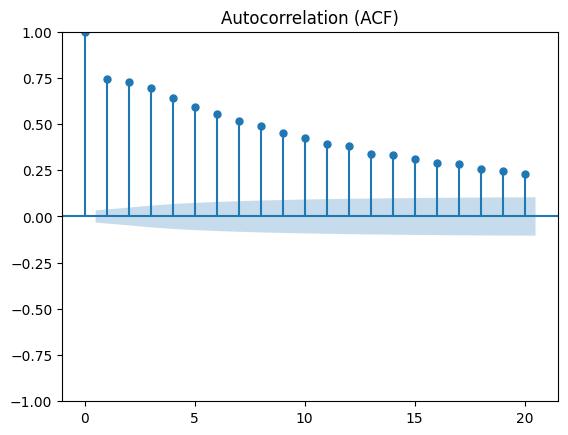

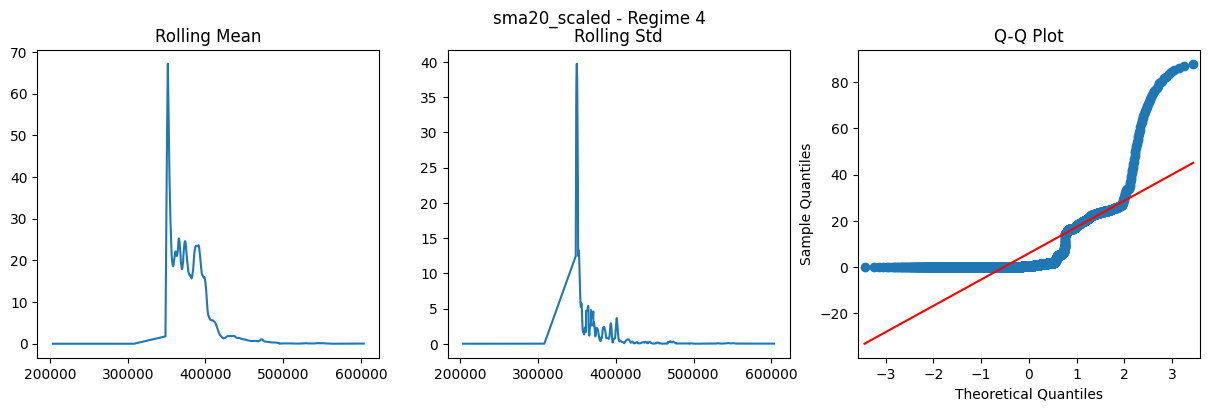

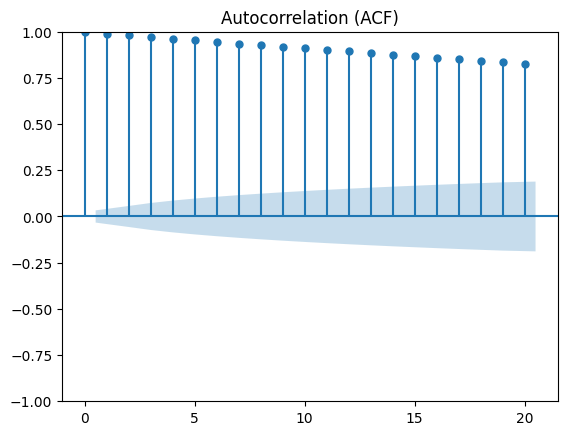

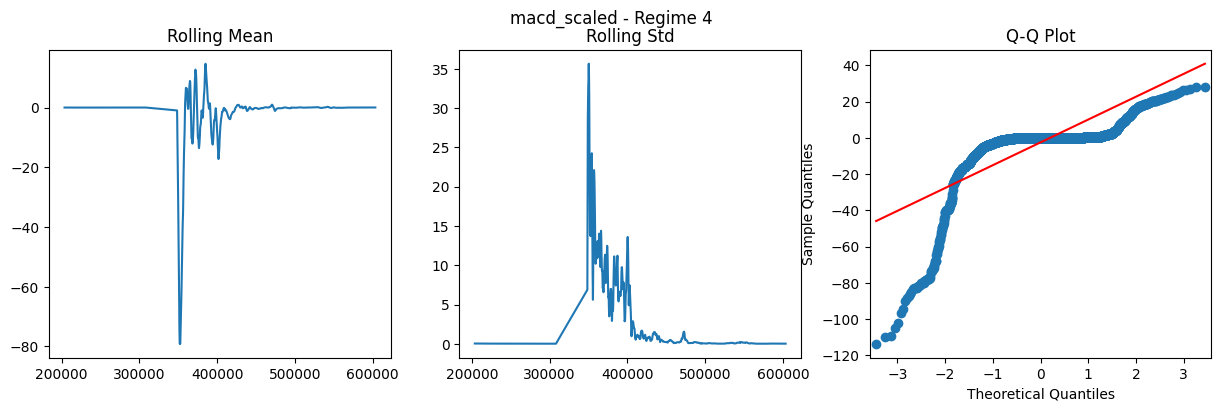

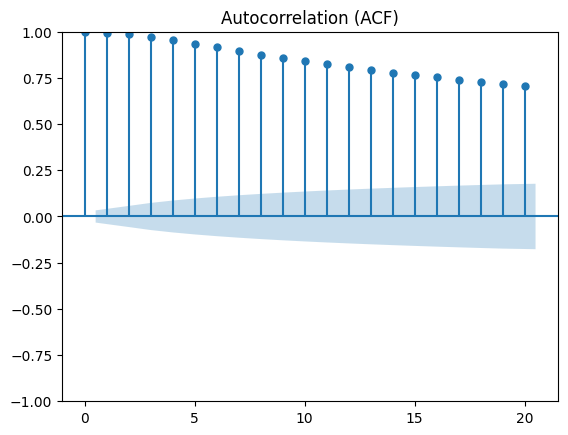

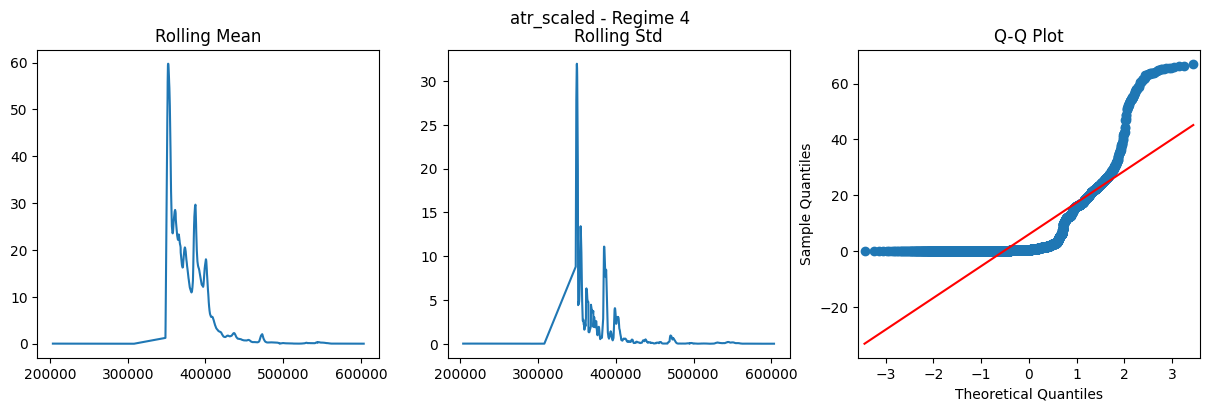

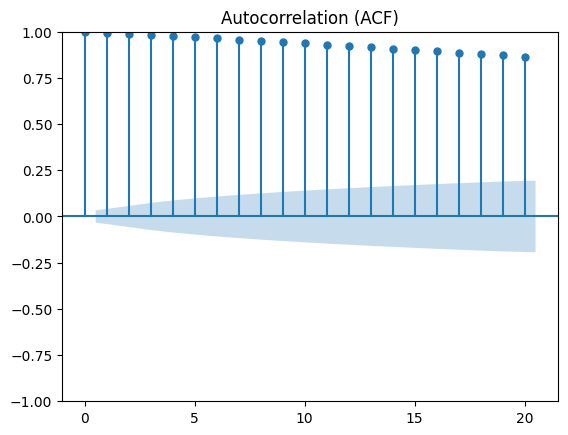

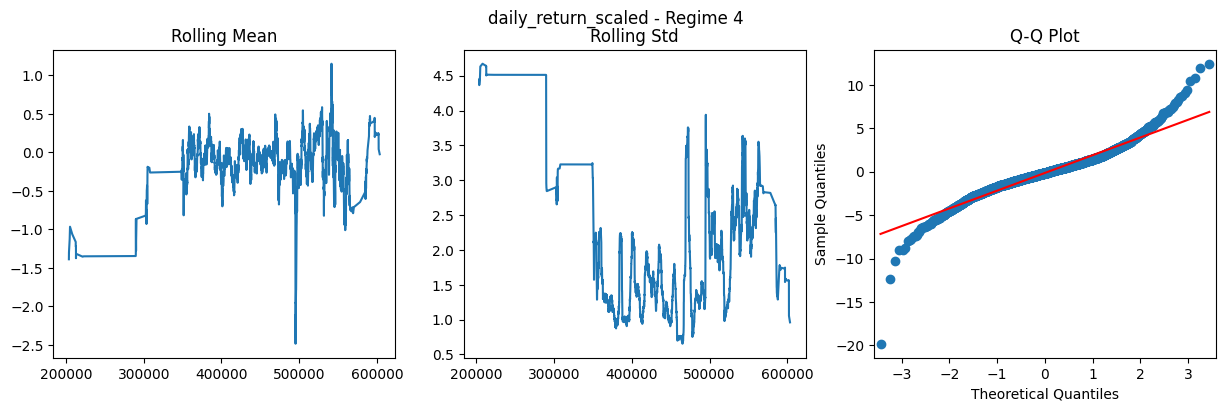

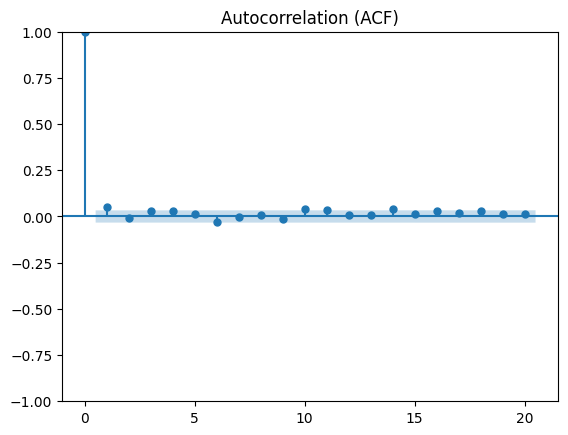

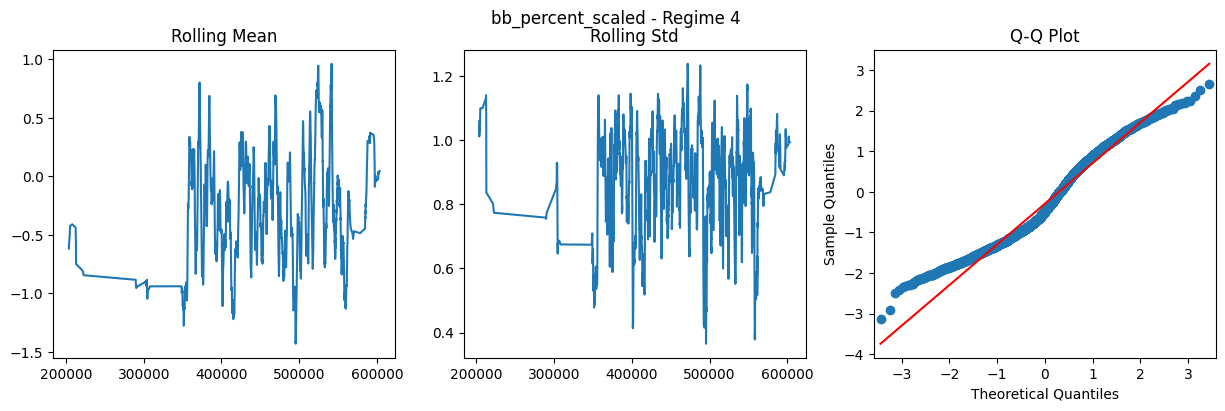

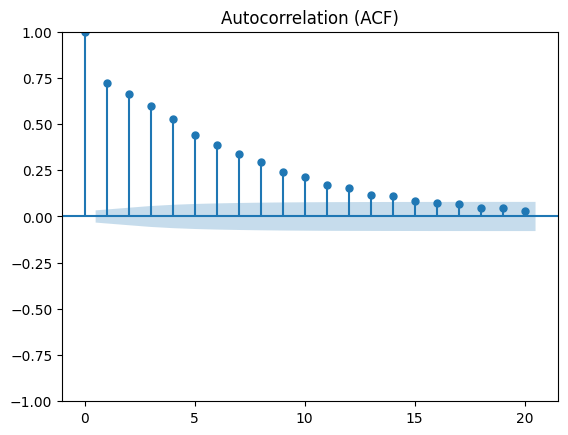

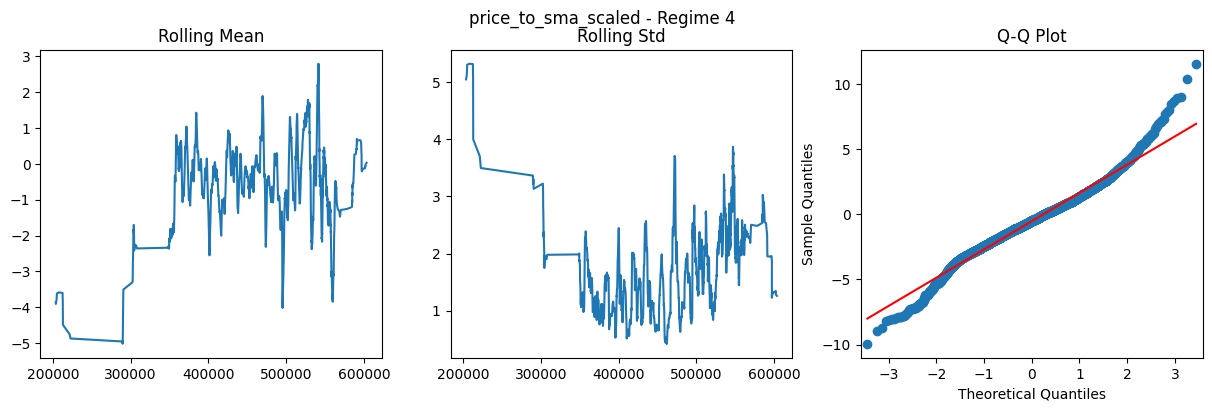

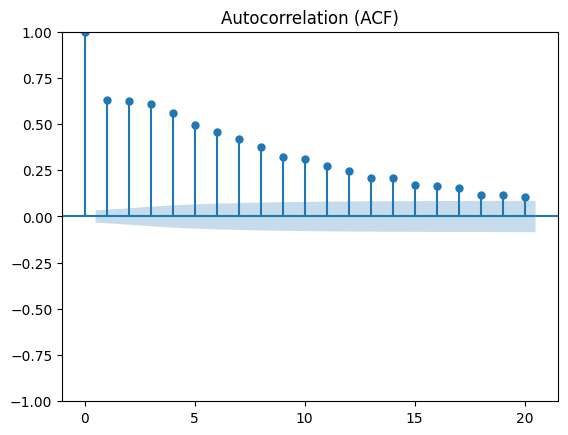

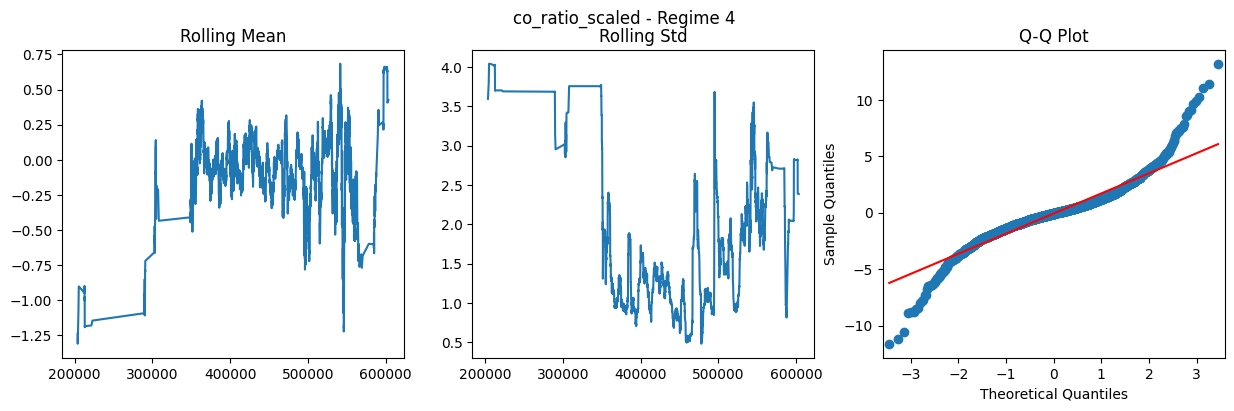

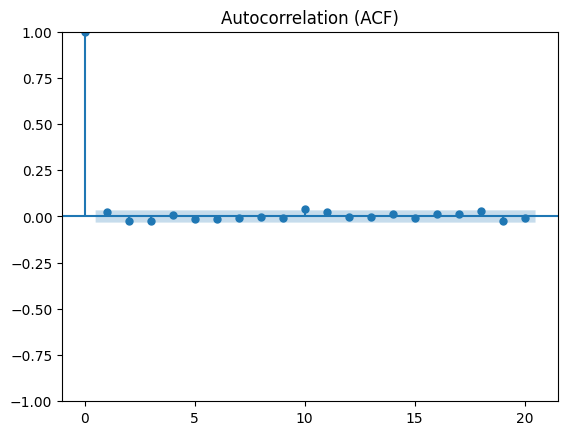

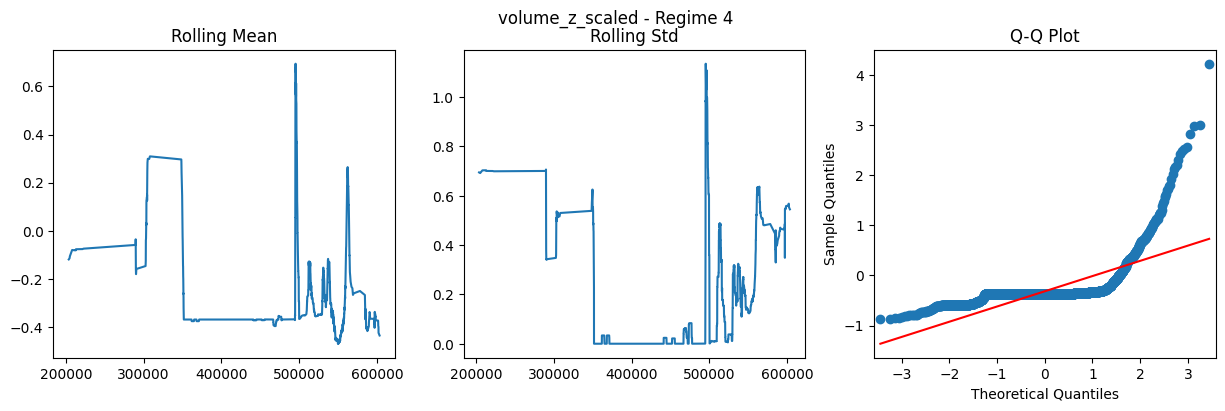

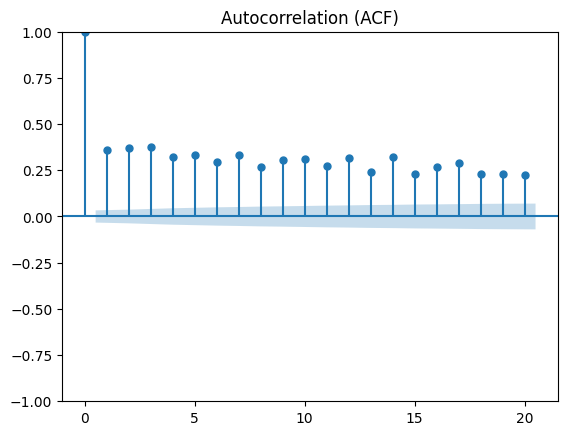

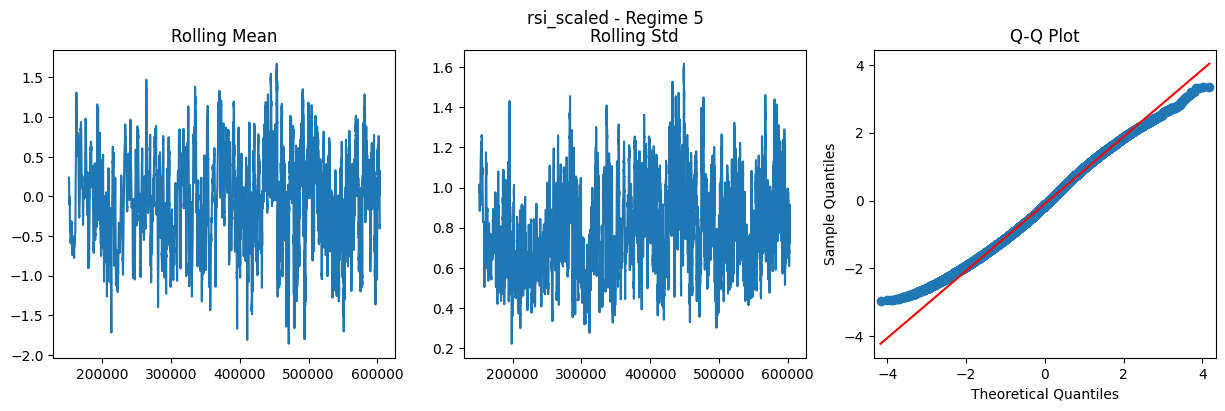

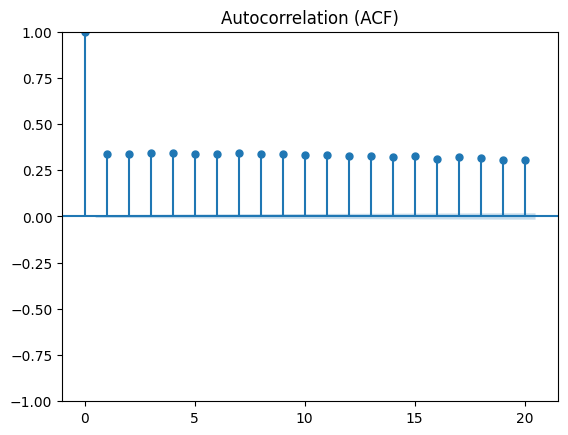

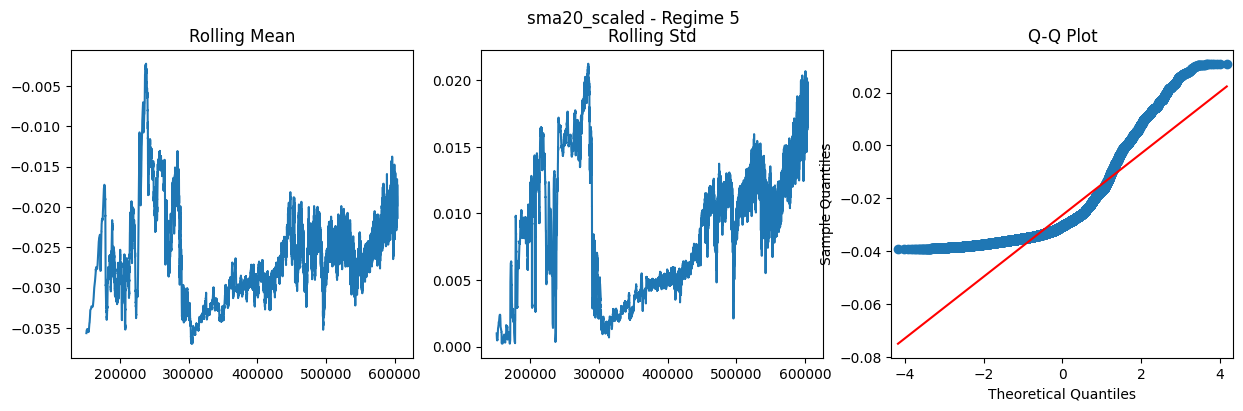

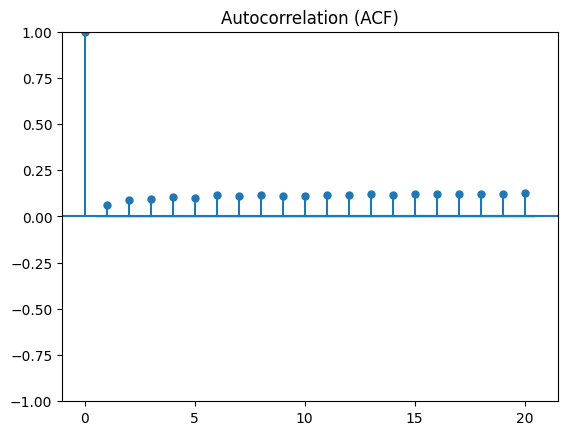

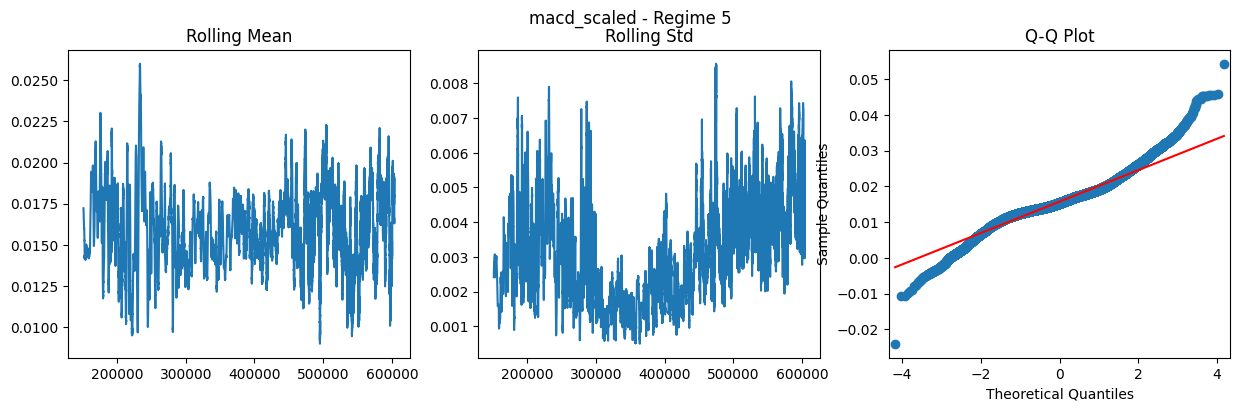

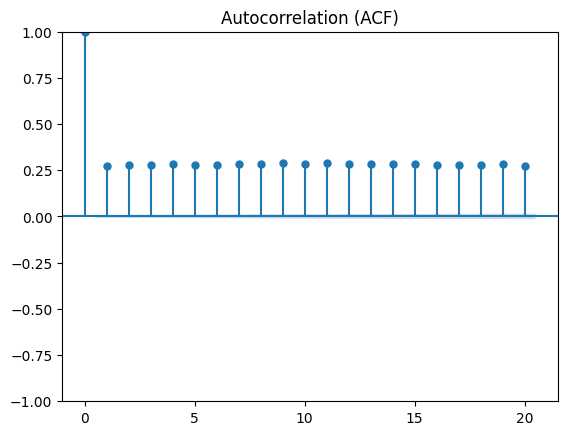

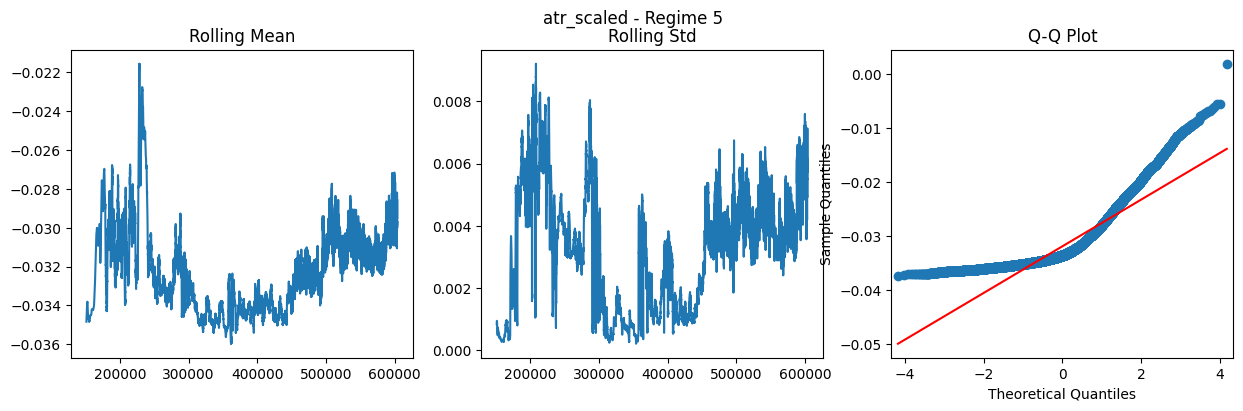

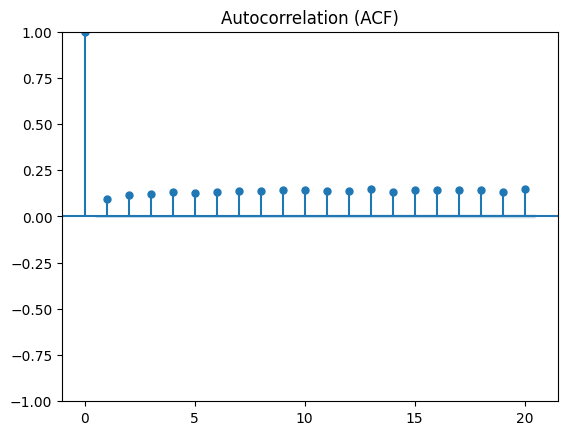

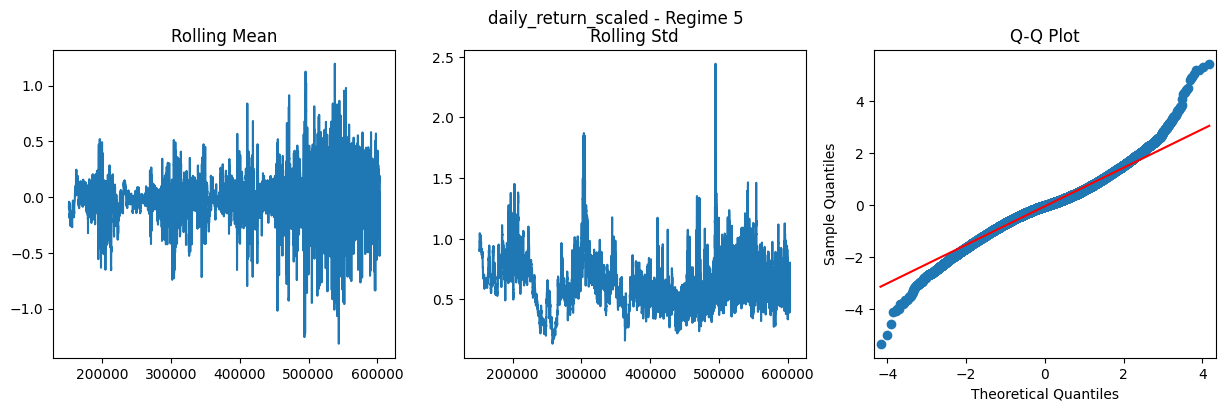

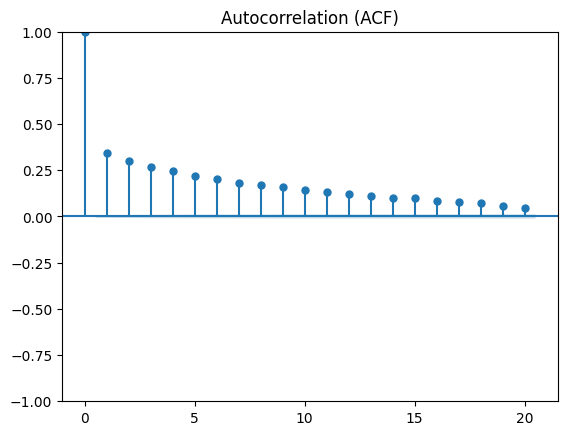

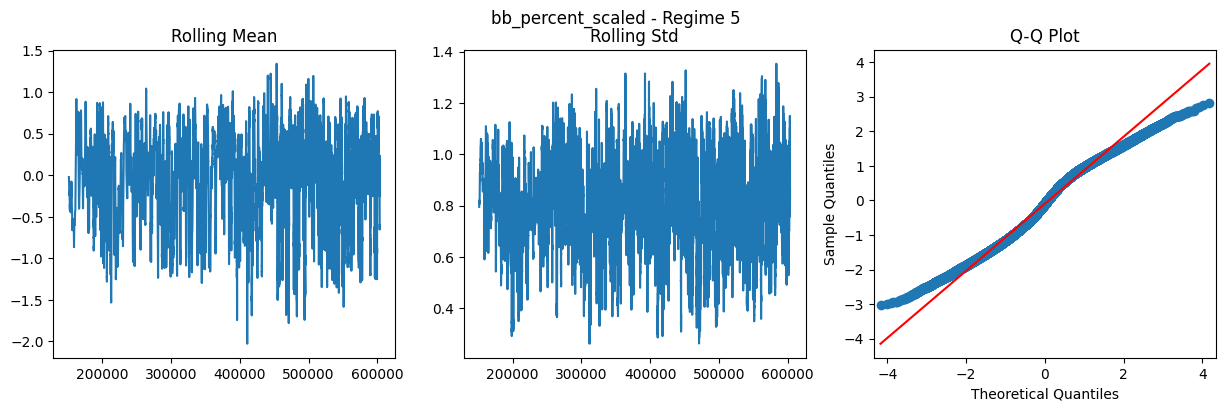

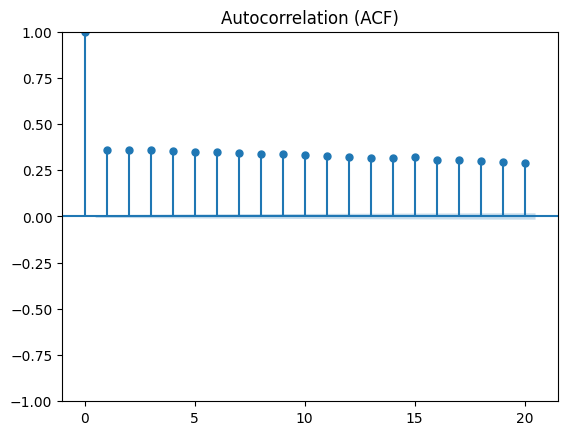

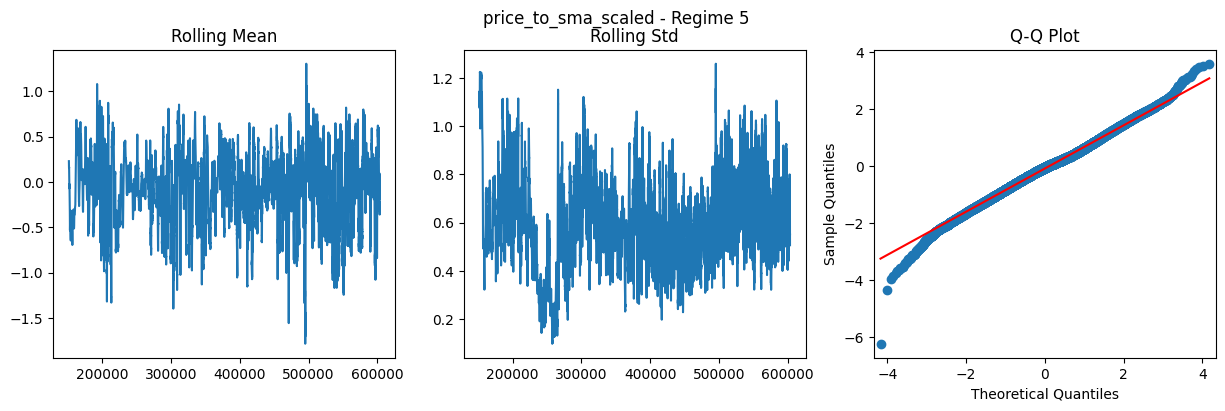

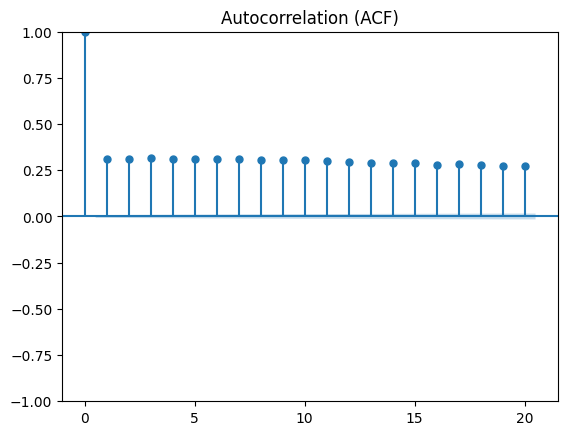

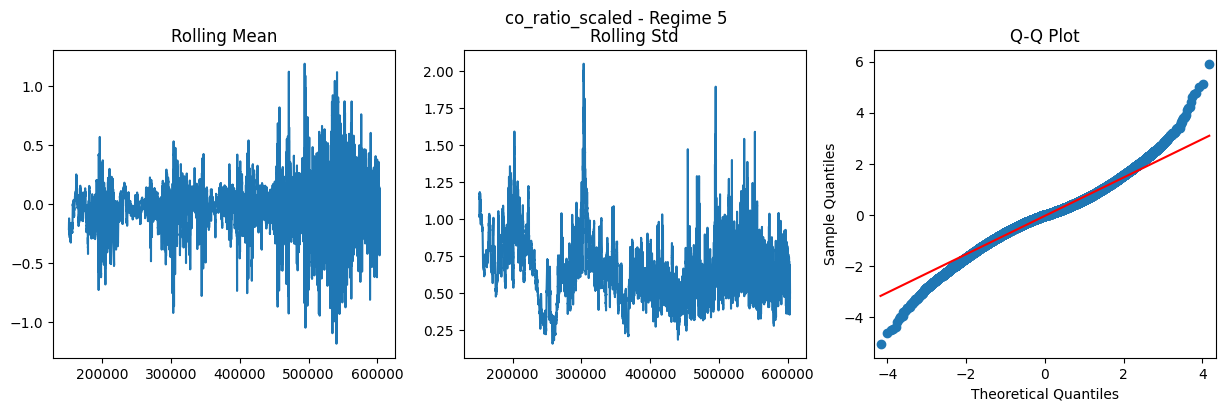

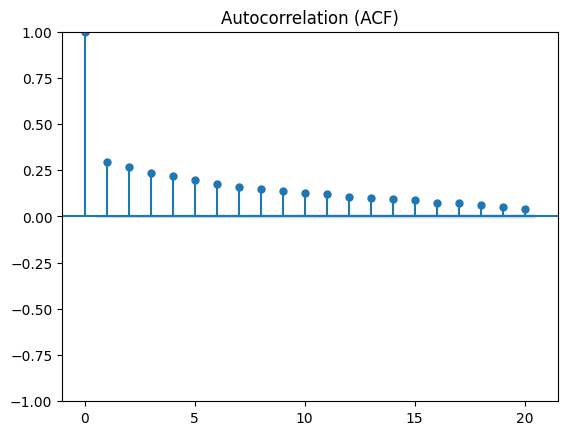

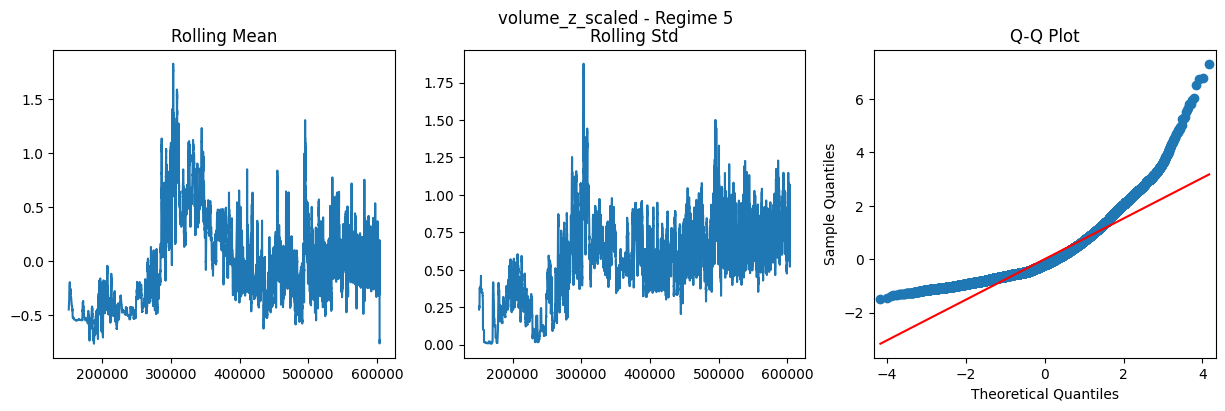

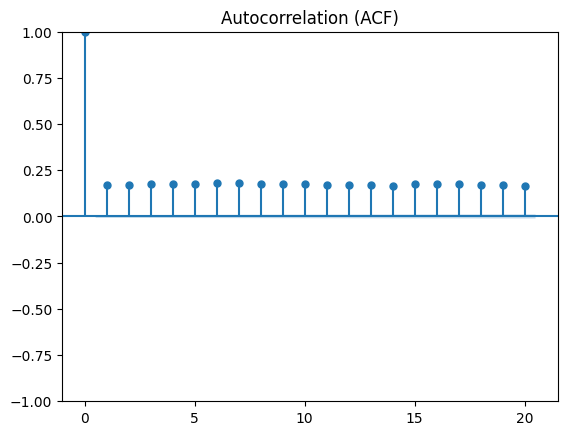

In [16]:
diagnostic_results = hmm_assumption_diagnostics(
    df_regime,
    features= scaled_cols,
    regime_col="regime",
    date_col="Date",
    plot=True 
)

In [17]:
diagnostic_results

Regime              Feature  ADF_p (Stationarity)  Shapiro_p (Normality)  \
0        0           rsi_scaled          0.000000e+00           8.746810e-05   
1        0         sma20_scaled          9.957992e-11           1.285620e-55   
2        0          macd_scaled          2.363083e-27           3.135689e-65   
3        0           atr_scaled          1.614954e-13           2.446550e-63   
4        0  daily_return_scaled          0.000000e+00           7.847120e-20   
5        0    bb_percent_scaled          0.000000e+00           4.838131e-24   
6        0  price_to_sma_scaled          0.000000e+00           4.877134e-05   
7        0      co_ratio_scaled          0.000000e+00           4.590689e-29   
8        0      volume_z_scaled          1.083065e-25           1.297610e-39   
9        1           rsi_scaled          1.986574e-18           3.571613e-24   
10       1         sma20_scaled          1.091391e-13           9.916818e-70   
11       1          macd_scaled          2.325612e-10           4.610217e-59   
12       1           atr_scaled          4.845985e-11           5.656953e-66   
13       1  daily_return_scaled          0.000000e+00           5.723695e-62   
14       1    bb_percent_scaled          1.106730e-23           2.158188e-31   
15       1  price_to_sma_scaled          1.470383e-22           2.978962e-39   
16       1      co_ratio_scaled          0.000000e+00           1.945723e-58   
17       1      volume_z_scaled          2.300937e-13           1.425253e-64   
18       2           rsi_scaled          0.000000e+00           6.914440e-06   
19       2         sma20_scaled          1.340117e-18           5.259332e-50   
20       2          macd_scaled          7.134421e-24           3.035081e-35   
21       2           atr_scaled          1.365292e-20           2.563206e-46   
22       2  daily_return_scaled          0.000000e+00           7.434374e-07   
23       2    bb_percent_scaled          0.000000e+00           1.387954e-21   
24       2  price_to_sma_scaled          0.000000e+00           3.221099e-02   
25       2      co_ratio_scaled          0.000000e+00           5.263203e-11   
26       2      volume_z_scaled          5.102798e-28           1.186563e-40   
27       3           rsi_scaled          2.028313e-30           7.484246e-13   
28       3         sma20_scaled          2.946690e-23           2.811249e-44   
29       3          macd_scaled          7.209588e-24           4.675076e-36   
30       3           atr_scaled          1.294706e-18           3.386399e-46   
31       3  daily_return_scaled          0.000000e+00           2.804145e-21   
32       3    bb_percent_scaled          0.000000e+00           4.114140e-32   
33       3  price_to_sma_scaled          0.000000e+00           5.717987e-09   
34       3      co_ratio_scaled          0.000000e+00           1.451391e-18   
35       3      volume_z_scaled          1.304389e-25           5.125633e-50   
36       4           rsi_scaled          4.505650e-19           1.828790e-16   
37       4         sma20_scaled          1.658851e-03           2.088290e-68   
38       4          macd_scaled          1.847749e-05           1.359144e-73   
39       4           atr_scaled          8.815232e-03           3.922816e-68   
40       4  daily_return_scaled          0.000000e+00           4.023906e-34   
41       4    bb_percent_scaled          3.378818e-26           3.475649e-28   
42       4  price_to_sma_scaled          8.030042e-18           1.454097e-22   
43       4      co_ratio_scaled          0.000000e+00           2.611716e-40   
44       4      volume_z_scaled          6.241280e-07           1.577200e-75   
45       5           rsi_scaled          1.181956e-25           8.610742e-12   
46       5         sma20_scaled          3.073106e-12           4.507352e-62   
47       5          macd_scaled          2.342905e-19           2.554116e-39   
48       5           atr_scaled          2.024335e-13           1.866515e-61   
49  

Main takeaways: stationarity passes, normality and independence fail
- independence failing is expected because in a time series, each observation is partly predictable from yesterday's value
- some characteristics of financial time series includes:
	- Autocorrelation: Returns or features (like RSI, MACD, volume) often show serial correlation, meaning today’s value is partly predictable from yesterday’s value.
	- Volatility clustering: High-volatility periods (like during market crashes) tend to cluster together, creating time dependence in variance.
	- Market microstructure effects: Prices react to order flow, news, and liquidity, creating dependencies between successive time points.

Next, I want to address the normality problem

In [18]:
def transform_features_for_normality(df, features):
    """
    Automatically detects skewness and applies transformations to improve normality.
    Prints before/after Shapiro-Wilk p-values for each feature.

    Rules:
      - Winsorize extreme outliers
      - Log transform positive skewed features (volume, ATR)
      - Logit transform bounded [0,1] or [0,100] features (RSI, BB%)
      - Power/Yeo-Johnson transform remaining non-normal features
    """
    df = df.copy()
    summary = []
    
    for feature in features:
        series = df[feature].dropna()

        if len(series) < 30:
            summary.append({"Feature": feature, "Before_p": np.nan, "After_p": np.nan, "Transform": "Skipped"})
            continue

        # --- 1) Initial normality test ---
        try:
            before_p = shapiro(series.sample(min(5000, len(series))))[1]
        except:
            before_p = np.nan

        transformed = series.copy()
        transform_used = "None"

        # --- 2) Winsorize extreme outliers ---
        lower = series.quantile(0.01)
        upper = series.quantile(0.99)
        transformed = transformed.clip(lower, upper)

        # --- 3) Log transform for volume/ATR or strong positive skew ---
        if (feature.lower().startswith("volume") or "atr" in feature.lower()) and (transformed > 0).all():
            transformed = np.log1p(transformed)
            transform_used = "Log"

        # --- 4) Logit transform for bounded features (0-1 or 0-100) ---
        if transformed.min() >= 0 and transformed.max() <= 1.1:
            transformed = np.log((transformed + 1e-6) / (1 - transformed + 1e-6))
            transform_used = "Logit"
        elif transformed.min() >= 0 and transformed.max() <= 100:
            normed = transformed / 100
            transformed = np.log((normed + 1e-6) / (1 - normed + 1e-6))
            transform_used = "Logit"

        # --- 5) Power Transform if still non-normal ---
        after_first = shapiro(pd.Series(transformed).dropna().sample(min(5000, len(transformed))))[1]
        if after_first < 0.05:
            pt = PowerTransformer(method='yeo-johnson')
            transformed = pt.fit_transform(transformed.values.reshape(-1, 1)).flatten()
            transform_used = transform_used + " + Power" if transform_used != "None" else "Power"

        # Save transformed values back
        df[feature] = transformed

        # --- 6) After transformation test ---
        try:
            after_p = shapiro(df[feature].dropna().sample(min(5000, len(df[feature]))))[1]
        except:
            after_p = np.nan

        summary.append({
            "Feature": feature,
            "Before_p": before_p,
            "After_p": after_p,
            "Transform": transform_used
        })

    # Print summary
    print("\n=== Normality Transformation Summary ===")
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))
    
    return df, summary_df

In [19]:
df_regime_normalized, normality_summary = transform_features_for_normality(df_regime, scaled_cols)


=== Normality Transformation Summary ===
            Feature     Before_p      After_p     Transform
         rsi_scaled 1.215447e-01 1.402693e-14         Power
       sma20_scaled 1.231317e-95 9.638680e-49         Power
        macd_scaled 1.223620e-95 5.972072e-71 Logit + Power
         atr_scaled 2.921456e-95 1.685007e-47         Power
daily_return_scaled 1.261278e-57 9.533845e-38         Power
  bb_percent_scaled 5.316754e-24 1.055090e-26         Power
price_to_sma_scaled 2.816532e-52 2.476706e-34         Power
    co_ratio_scaled 8.538492e-57 1.592317e-39         Power
    volume_z_scaled 2.783334e-67 2.135193e-17         Power


Main Takeaways: despite transformations to the the features, the p-values of the Shapiro-Wilk test are still significantly below 0.05.

This is more or less normal (haha) in time series because:
- stock data often has fat tails, skewness, and volatility clustering
- price returns often follow heavy-tailed distributions, not Gaussian

So I can only conclude that: 
- HMM with Gaussian assumptions may not fully capture real data patterns unless a change in the emission distribution

So my options: 
- alternative models:
    - Student-t HMM
        - deals with fat tails better with degrees of freedom parameter handling tail heaviness but much harder estimating the DoF and higher dimensions makes it harder to to estimate mean/covariance 
    - Gaussian Mixture HMM
        - can approximate any non-normal distribution if K is large enough but too big K leads to overfitting and approximates heavy tails
- More feature engineering 
    - might lose economic meaning of features

After some more research, I believe a gaussian mixture tuned similar to student-t may be the best choice for my current implementation

GAUSSIAN MIXTURE HMM

In [20]:
from hmmlearn.hmm import GMMHMM

def train_gmmhmm_model(X, n_states=6, n_mix=3, covariance_type='full', n_iter=1000, tol = 0.01, random_state=42):
    """
    Trains a GMMHMM model on the given feature matrix.

    Parameters:
        X (np.ndarray): Feature matrix (n_samples, n_features)
        n_states (int): Number of hidden regimes
        n_mix (int): Number of Gaussian mixtures per regime
        covariance_type (str): Type of covariance ('full', 'diag', 'tied', 'spherical')
        n_iter (int): Maximum number of iterations
        random_state (int): Random seed

    Returns:
        model (GMMHMM): Trained GMMHMM model
        hidden_states (np.ndarray): Predicted regime sequence
    """
    model = GMMHMM(
        n_components=n_states,
        n_mix=n_mix,
        covariance_type=covariance_type,
        n_iter=n_iter,
        random_state=random_state,
        tol = tol,
        verbose=True
    )
    model.fit(X)
    hidden_states = model.predict(X)
    return model, hidden_states

In [21]:
gmm_model, regimes_gmm = train_gmmhmm_model(X)

# Add GMMHMM regimes to dataframe
df_regime["regime_gmm"] = regimes_gmm

         1 -5079451.00239319             +nan
         2  768804.72649601 +5848255.72888920
         3 5131574.36299358 +4362769.63649758
         4 6430461.99552500 +1298887.63253141
         5 6961222.79488217 +530760.79935717
         6 7215489.96507148 +254267.17018931
         7 7376251.18217760 +160761.21710612
         8 7502997.71459353 +126746.53241592
         9 7619652.34981035 +116654.63521683
        10 7723592.34817766 +103939.99836731
        11 7800709.74620094  +77117.39802328
        12 7860002.45476778  +59292.70856684
        13 7911382.79263362  +51380.33786584
        14 7954829.30642600  +43446.51379238
        15 7989215.10230878  +34385.79588278
        16 8015927.64511571  +26712.54280693
        17 8036860.63038881  +20932.98527310
        18 8053727.30250093  +16866.67211212
        19 8067904.09876685  +14176.79626593
        20 8080191.89807843  +12287.79931157
        21 8091020.21855253  +10828.32047410
        22 8100770.11308276   +9749.89453023
      

GMMHMM model converges at the 794 iteration with tolerance set at 0.01. 

In [22]:
df_regime

Date Ticker       Open       High        Low      Close  \
1      1962-02-06     KO   0.003769   0.003769   0.003719   0.003719   
2      1962-02-06     BA   0.205256   0.205728   0.200066   0.205256   
3      1962-02-07     BA   0.205256   0.209031   0.203841   0.205256   
5      1962-02-07     KO   0.003719   0.003739   0.003719   0.003739   
7      1962-02-08     BA   0.205728   0.209031   0.205728   0.205728   
...           ...    ...        ...        ...        ...        ...   
603515 2024-11-04   HOOD  23.750000  23.900000  23.540100  23.889999   
603516 2024-11-04    CSX  33.470001  33.805000  33.369999  33.770000   
603517 2024-11-04    FCX  45.599998  46.160000  45.626900  46.110001   
603518 2024-11-04   ITUB   6.060000   6.165000   6.125000   6.160000   
603519 2024-11-04    SLB  40.160000  40.349998  39.930000  40.340000   

           Volume  Dividends  Stock Splits        rsi  ...  sma20_scaled  \
1        691200.0        0.0           0.0  45.517039  ...     -0.039800   
2        801900.0        0.0           0.0  65.384446  ...     -0.039777   
3        844425.0        0.0           0.0  65.384446  ...     -0.039777   
5        192000.0        0.0           0.0  47.470303  ...     -0.039800   
7        656100.0        0.0           0.0  66.102568  ...     -0.039776   
...           ...        ...           ...        ...  ...           ...   
603515  1394526.0        0.0           0.0  42.221555  ...     -0.036599   
603516   680096.0        0.0           0.0  49.148475  ...     -0.035679   
603517   487766.0        0.0           0.0  44.584281  ...     -0.034030   
603518   987570.0        0.0           0.0  45.167088  ...     -0.039048   
603519   567642.0        0.0           0.0  38.979635  ...     -0.034664   

        macd_scaled  atr_scaled  daily_return_scaled  bb_percent_scaled  \
1          0.015255   -0.037813            -0.448115          -0.166291   
2          0.015267   -0.037804            -0.026793           0.586808   
3          0.015266   -0.037804            -0.026793           0.524947   
5          0.015255   -0.037814             0.143994           0.025860   
7          0.015266   -0.037804             0.046791           0.512209   
...             ...         ...                  ...                ...   
603515     0.016016   -0.035429            -0.133672          -1.540481   
603516     0.014932   -0.036489             0.337659          -0.305294   
603517     0.014581   -0.035345             0.338471          -0.934255   
603518     0.015090   -0.037553             1.159270          -0.421571   
603519     0.013859   -0.035875             0.440356          -1.007108   

        price_to_sma_scaled  co_ratio_scaled  volume_z_scaled  regime  \
1                 -0.098431        -0.513906        -1.103729       0   
2                  0.420899        -0.004523        -0.593125       0   
3                  0.352324        -0.004523        -0.584708       0   
5                  0.006188         0.201947        -1.166319       0   
7                  0.321818        -0.004523        -0.621983       0   
...                     ...              ...              ...     ...   
603515            -1.369285         0.223694        -1.015806       3   
603516            -0.146788         0.342494        -1.067040       2   
603517            -0.483985         0.428482        -1.020736       2   
603518            -0.153255         0.634347        -1.317720       3   
603519            -0.713041         0.169003        -1.220417       2   

        regime_gmm  
1                0  
2                0  
3                0  
5                0  
7                0  
...            ...  
603515           3  
603516           5  
603517           3  
603518           2  
603519           3  

[580111 rows x 29 columns]

In [23]:
def compare_hmm_models(df, price_col="Close", 
                       gauss_model=None, gmm_model=None, 
                       gauss_states=None, gmm_states=None):
    """
    Compare GaussianHMM and GMMHMM models on multiple metrics.

    Parameters:
        df (pd.DataFrame): DataFrame containing prices and returns
        price_col (str): Column name for price
        gauss_model (GaussianHMM): Trained GaussianHMM model
        gmm_model (GMMHMM): Trained GMMHMM model
        gauss_states (np.ndarray): Hidden states predicted by GaussianHMM
        gmm_states (np.ndarray): Hidden states predicted by GMMHMM

    Returns:
        metrics_df (pd.DataFrame): Comparison of metrics for both models
    """
    results = []

    # Compute log-likelihoods
    ll_gauss = gauss_model.score(df[features_to_use])
    ll_gmm = gmm_model.score(df[features_to_use])
    
    # AIC and BIC for GaussianHMM
    k_gauss = gauss_model.n_components * (gauss_model.n_features * 2)  # rough param count
    aic_gauss = 2*k_gauss - 2*ll_gauss
    bic_gauss = np.log(len(df)) * k_gauss - 2*ll_gauss
    
    # AIC and BIC for GMMHMM
    k_gmm = gmm_model.n_components * gmm_model.n_mix * (gmm_model.n_features * 2)
    aic_gmm = 2*k_gmm - 2*ll_gmm
    bic_gmm = np.log(len(df)) * k_gmm - 2*ll_gmm

    # Calculate returns
    df["return"] = df[price_col].pct_change().fillna(0)

    # Sharpe ratio & mean returns for each regime
    def regime_metrics(states, label):
        temp = df.copy()
        temp["regime"] = states
        metrics = []
        for state in np.unique(states):
            regime_returns = temp.loc[temp["regime"] == state, "return"]
            mean_ret = np.mean(regime_returns)
            std_ret = np.std(regime_returns)
            sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret > 0 else 0
            metrics.append({
                "Model": label,
                "Regime": state,
                "Mean_Return": mean_ret,
                "Sharpe_Ratio": sharpe
            })
        return pd.DataFrame(metrics)

    regime_gauss = regime_metrics(gauss_states, "GaussianHMM")
    regime_gmm = regime_metrics(gmm_states, "GMMHMM")

    # Combine results
    model_metrics = pd.DataFrame([
        {"Model": "GaussianHMM", "LogLikelihood": ll_gauss, "AIC": aic_gauss, "BIC": bic_gauss},
        {"Model": "GMMHMM", "LogLikelihood": ll_gmm, "AIC": aic_gmm, "BIC": bic_gmm},
    ])

    metrics_df = {
        "ModelMetrics": model_metrics,
        "RegimeMetrics": pd.concat([regime_gauss, regime_gmm])
    }

    return metrics_df

In [24]:
metrics = compare_hmm_models(
    df_regime,
    price_col="Close",
    gauss_model=gaussian_model,
    gmm_model=gmm_model,
    gauss_states=gauss_states,
    gmm_states=regimes_gmm
)

print("==== Model-Level Metrics ====")
print(metrics["ModelMetrics"])

print("\n==== Regime-Level Metrics ====")
print(metrics["RegimeMetrics"])

==== Model-Level Metrics ====
         Model  LogLikelihood           AIC           BIC
0  GaussianHMM  -3.205773e+12  6.411545e+12  6.411545e+12
1       GMMHMM  -4.235498e+12  8.470996e+12  8.470996e+12

==== Regime-Level Metrics ====
         Model  Regime   Mean_Return  Sharpe_Ratio
0  GaussianHMM       0   2384.261513      0.790155
1  GaussianHMM       1    220.295461      0.169536
2  GaussianHMM       2    783.210399      0.239538
3  GaussianHMM       3    739.193783      0.287752
4  GaussianHMM       4   9892.182650      1.781276
5  GaussianHMM       5     15.623230      1.805643
0       GMMHMM       0   2572.547305      0.758894
1       GMMHMM       1  80196.574475      3.952997
2       GMMHMM       2    996.731514      0.290873
3       GMMHMM       3    510.110914      0.233782
4       GMMHMM       4  12387.020058      2.375654
5       GMMHMM       5    283.547905      0.165691


From this output:

Global Fit (Model-Level Metrics)
- GaussianHMM has:
    - Higher log-likelihood (less negative),
	- Lower AIC/BIC,  meaning it fits the entire dataset better overall with fewer penalties for complexity.
- GMMHMM has:
	- Worse log-likelihood,
	- Higher AIC/BIC, suggesting the added mixture complexity isn’t improving global model fit enough to offset the penalty for extra parameters.

Regime-Level Fit (Regime-Level Metrics)

Here’s where it gets interesting:
- GMMHMM absolutely dominates in some regimes:
- Regime 1: Sharpe Ratio 3.95 vs Gaussian’s 0.17, a huge jump in quality.
- Regime 4: Sharpe 2.37 vs Gaussian’s 1.78,  meaningful improvement.
- In other regimes, it’s roughly similar or worse.

Interpretation
- GaussianHMM is the better global fit (lower complexity cost, more stable overall likelihood).
- GMMHMM is the better regime specialist — it nails certain states with extremely high returns and Sharpe ratios but at the cost of worse overall model metrics.
- For financial regime detection, we often care less about perfect global fit and more about identifying high-performance regimes, making the GMMHMM results might actually be more actionable, especially if we only trade in its high-Sharpe regimes.

In [25]:
# ---------- 1) Regime stats (Sharpe, mean) ----------

def regime_stats(df, regimes, price_col="Close"):
    temp = df.copy()
    temp["regime"] = regimes
    temp["ret"] = temp[price_col].pct_change().fillna(0.0)

    rows = []
    for s in np.unique(regimes):
        r = temp.loc[temp["regime"] == s, "ret"]
        mean = r.mean()
        std  = r.std()
        sharpe = (mean / std * np.sqrt(252)) if std > 0 else 0.0
        rows.append({"regime": int(s), "mean": mean, "std": std, "sharpe": sharpe, "count": len(r)})
    return pd.DataFrame(rows).sort_values("sharpe", ascending=False)


In [26]:
# ---------- 2) Pick tradeable regimes ----------
def select_trade_regimes(stats_df, top_k=2, sharpe_min=None):
    ranked = stats_df.sort_values("sharpe", ascending=False)
    if sharpe_min is not None:
        ranked = ranked[ranked["sharpe"] >= sharpe_min]
    if top_k is not None:
        ranked = ranked.head(top_k)
    return ranked["regime"].tolist(), ranked

In [27]:
# ---------- 3) Backtest: long when regime in trade_regimes and confidence ≥ min_prob ----------
def backtest_regime_filter(df, price_col, regimes, model, X, trade_regimes,
                           min_prob=0.0, tc_bps=1.0):
    """
    min_prob: require max posterior prob ≥ min_prob (e.g., 0.6) to take a position
    tc_bps: round-trip transaction cost in basis points deducted on position flips
    """
    temp = df.copy()
    temp["ret"] = temp[price_col].pct_change().fillna(0.0)

    # Posterior probabilities (confidence)
    post = model.predict_proba(X)         # shape: (n_samples, n_states)
    max_prob = post.max(axis=1)

    # Position: 1 when regime in trade set AND confidence high, else 0 (flat)
    pos_raw = np.where((np.isin(regimes, trade_regimes)) & (max_prob >= min_prob), 1.0, 0.0)
    temp["position"] = pd.Series(pos_raw, index=temp.index)

    # One-bar delay to avoid look-ahead
    temp["position_shift"] = temp["position"].shift(1).fillna(0.0)

    # Transaction cost when position flips (enter/exit)
    flips = temp["position_shift"].diff().abs().fillna(0.0)
    tc = (tc_bps / 10000.0) * flips

    # Strategy return
    temp["strat_ret"] = temp["position_shift"] * temp["ret"] - tc

    # Cumulative curves
    temp["cum_strat"] = (1.0 + temp["strat_ret"]).cumprod()
    temp["cum_bh"]    = (1.0 + temp["ret"]).cumprod()

    # Quick stats
    def annualized_stats(r):
        mean = r.mean() * 252
        vol  = r.std() * np.sqrt(252)
        sharpe = mean / vol if vol > 0 else 0.0
        dd = (temp["cum_strat"].cummax() - temp["cum_strat"]).max()
        return mean, vol, sharpe, dd

    ann_mean, ann_vol, ann_sharpe, max_dd = annualized_stats(temp["strat_ret"])

    perf = {
        "trade_regimes": trade_regimes,
        "min_prob": min_prob,
        "tc_bps": tc_bps,
        "final_cum_strategy": float(temp["cum_strat"].iloc[-1]),
        "final_cum_buyhold": float(temp["cum_bh"].iloc[-1]),
        "ann_return": ann_mean,
        "ann_vol": ann_vol,
        "sharpe": ann_sharpe,
        "max_drawdown": max_dd
    }

    # Plot
    plt.figure(figsize=(11,5))
    plt.plot(temp.index, temp["cum_bh"], label="Buy & Hold", linestyle="--")
    plt.plot(temp.index, temp["cum_strat"], label="Regime Filter (long only)")
    plt.title("Cumulative Returns: Regime Filter vs Buy & Hold")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return temp, perf

GMMHMM regime stats (sorted by Sharpe):
    regime          mean            std    sharpe   count
1       1  80196.574475  323361.150674  3.937026     124
4       4  12387.020058   82792.799475  2.375060    1998
0       0   2572.547305   53812.640002  0.758891  144434
2       2    996.731514   54397.174226  0.290872  145547
3       3    510.110914   34638.193111  0.233781  157991
5       5    283.547905   27166.162018  0.165691  130017 

Chosen regimes: [1, 4]
   regime          mean            std    sharpe  count
1       1  80196.574475  323361.150674  3.937026    124
4       4  12387.020058   82792.799475  2.375060   1998 



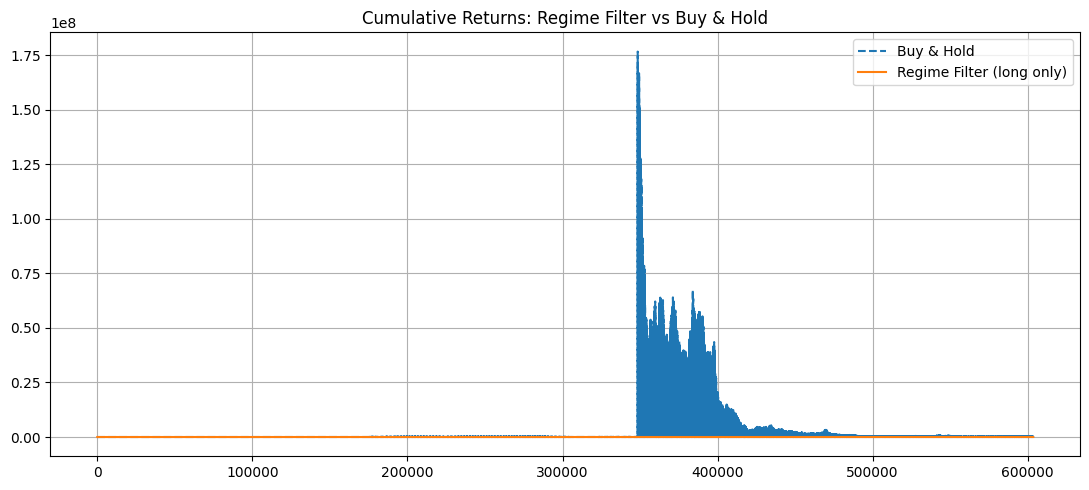

Performance summary:
 trade_regimes              [1, 4]
min_prob                      0.6
tc_bps                        2.0
final_cum_strategy            0.0
final_cum_buyhold     10845.60886
ann_return              -0.915868
ann_vol                  0.953001
sharpe                  -0.961035
max_drawdown             1.000121
dtype: object


In [28]:
# 4a) Compute regime stats for the GMMHMM predictions
gmm_stats = regime_stats(df_regime, regimes_gmm, price_col="Close")
print("GMMHMM regime stats (sorted by Sharpe):\n", gmm_stats, "\n")

# 4b) Choose tradeable regimes (example: top 2 by Sharpe, require Sharpe ≥ 0.5)
trade_regimes, chosen = select_trade_regimes(gmm_stats, top_k=2, sharpe_min=0.5)
print("Chosen regimes:", trade_regimes)
print(chosen, "\n")

# 4c) Backtest with optional confidence filter and transaction costs
bt_df, perf = backtest_regime_filter(
    df=df_regime,
    price_col="Close",
    regimes=regimes_gmm,
    model=gmm_model,
    X=X,                    # SAME features (rows aligned to df_regime.index)
    trade_regimes=trade_regimes,
    min_prob=0.60,          # e.g., only take trades when model is ≥60% confident
    tc_bps=2.0              # 2 bps per flip (enter/exit combined)
)

print("Performance summary:\n", pd.Series(perf))

From the results, a few things stand out:

1. Regime stats
- the GMMHMM found Regime 1 and Regime 4 as having the highest Sharpe ratios.
- These were chosen for trading (trade_regimes = [1, 4]).
- Regime 1 especially has an extremely high mean return and Sharpe ratio, which is suspiciously large and might be a result of outliers or very short periods with explosive returns (only 124 data points).

2. Backtest results
- final_cum_strategy = 0.0 means your regime-filtered strategy essentially went to zero, it completely wiped out at some point.
- Meanwhile, final_cum_buyhold is huge (10,845x growth), suggesting your dataset has some extreme price appreciation (maybe a long historical index or stock run).
- The annualized Sharpe for your strategy is negative (-0.96), so it’s underperforming random chance.
- Max drawdown = 1.0 means the strategy lost 100% of equity at some point, again, full wipeout.

3. Why the chart looks wrong (aside from bad scaling)
- The Buy & Hold curve explodes upward because of your extreme mean values, it likely hit an exponential rally.
- The Regime Filter line is flat at zero because once your equity goes to zero, cumulative returns can’t recover.
- Your chosen regimes likely picked up very short-lived, volatile spikes, but in reality these didn’t persist long enough to profit.

4. Potential reasons why this is happening
- Overfitting to high returns: GMMHMM chose the regimes with the biggest spikes, not the most sustainable.
- Mean/variance distortion: High mean return with huge std means unstable, even if Sharpe seems good.
- Confidence filter (min_prob=0.6) + limited trades might mean you barely took any trades, so one or two losses killed the portfolio.
- Possible lookahead bias if the regime classification is from the whole dataset without walk-forward training.

5. Next Steps
	1.	Use walk-forward or train/test split, avoid fitting the model on all historical data.
	2.	Inspect regime returns in time-series form, see when regimes 1 and 4 appear and if they make sense visually.
	3.	Avoid trading only 1–2 regimes, start with a broader set (top 50% Sharpe) to ensure diversification.
	4.	Lower mean return outliers, winsorize or remove unrealistic returns before calculating Sharpe.
	5.	Run the same backtest on GaussianHMM, compare stability.
	6.	Reduce min_prob, maybe 0.4 to increase trade frequency and reduce catastrophic wipeouts.

In [29]:
# ----- helpers -----
def _posterior_max(model, X):
    proba = model.predict_proba(X)
    return proba.max(axis=1), proba

def _build_positions(regimes, trade_regimes, max_prob, min_prob):
    return np.where((np.isin(regimes, trade_regimes)) & (max_prob >= min_prob), 1.0, 0.0)

def _trades_from_position(idx, position_shift):
    flips = position_shift.diff().fillna(position_shift.iloc[0]).values
    pos = position_shift.values
    dates = idx

    trades = []
    open_i = None
    for i in range(len(pos)):
        if flips[i] > 0 and pos[i] == 1:     # flat -> long
            open_i = i
        elif flips[i] < 0 and pos[i] == 0:   # long -> flat
            if open_i is not None:
                trades.append((dates[open_i], dates[i], 1))
                open_i = None
    if open_i is not None:
        trades.append((dates[open_i], dates[-1], 1))
    return trades

def _per_trade_stats(df, price_col, trades, tc_bps):
    rows = []
    for (entry_dt, exit_dt, side) in trades:
        sl = df.loc[entry_dt:exit_dt]
        if len(sl) < 2:
            continue
        p0 = sl[price_col].iloc[0]
        p1 = sl[price_col].iloc[-1]
        r = (p1/p0 - 1.0) * side
        r -= 2 * (tc_bps / 10000.0)
        curve = (sl[price_col] / p0 - 1.0) * side
        rows.append({
            "entry": entry_dt, "exit": exit_dt, "bars": len(sl)-1,
            "side": "long", "ret": r,
            "MFE": curve.max(), "MAE": curve.min()
        })
    return pd.DataFrame(rows)

# helper to pick a single ticker while keeping arrays aligned
def slice_ticker(df, X, regimes, ticker_col, ticker):
    mask = (df[ticker_col] == ticker).values
    df_s = df.loc[mask].copy()
    X_s = X[mask] if isinstance(X, np.ndarray) else X.loc[mask].values
    r_s = regimes[mask] if isinstance(regimes, np.ndarray) else np.asarray(regimes)[mask]
    return df_s, X_s, r_s

In [30]:
# ----- main backtest + plotly figs -----
def backtest_regime_filter_plotly(
    df, price_col, regimes, model, X, trade_regimes,
    min_prob=0.60, tc_bps=2.0, regime_alpha=0.10,
    ticker: str | None = None,            # used in titles only
    allow_short: bool = False,            # enable shorting
    short_regimes: list[int] | None = None, # which regimes to short (if None, none)
    size_by_prob: bool = False,           # size position by max posterior prob
    marker_size: int = 12                  # make trade signals bigger
):
    temp = df.copy()
    temp["ret"] = temp[price_col].pct_change().fillna(0.0)

    # confidence
    max_prob, post = _posterior_max(model, X)

    # build position allowing long, optional short, optional sizing
    reg = np.asarray(regimes)
    long_mask  = np.isin(reg, trade_regimes) & (max_prob >= min_prob)
    short_mask = np.zeros_like(long_mask, dtype=bool)
    if allow_short and short_regimes:
        short_mask = np.isin(reg, np.array(short_regimes)) & (max_prob >= min_prob)

    pos_raw = np.zeros_like(max_prob, dtype=float)
    pos_raw[long_mask]  = 1.0
    pos_raw[short_mask] = -1.0

    # optionally size by posterior probability (confidence‑weighted)
    if size_by_prob:
        pos_raw = pos_raw * max_prob

    temp["position"] = pd.Series(pos_raw, index=temp.index)
    # one‑bar delay to execute next bar
    temp["position_shift"] = temp["position"].shift(1).fillna(0.0)

    # costs proportional to position change magnitude (works for sized positions)
    delta_pos = temp["position_shift"].diff().abs().fillna(temp["position_shift"].abs())
    tc = (tc_bps / 10000.0) * delta_pos

    # strategy return
    temp["strat_ret"] = temp["position_shift"] * temp["ret"] - tc
    temp["cum_strat"] = (1.0 + temp["strat_ret"]).cumprod()
    temp["cum_bh"]    = (1.0 + temp["ret"]).cumprod()

    # trades from executed position
    trades = _trades_from_position(temp.index, temp["position_shift"])
    trades_df = _per_trade_stats(temp, price_col, trades, tc_bps)

    # summary
    ann_ret = temp["strat_ret"].mean() * 252
    ann_vol = temp["strat_ret"].std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else 0.0
    max_dd  = float((temp["cum_strat"].cummax() - temp["cum_strat"]).max())
    exposure = float(temp["position_shift"].abs().mean())  # abs for sized/short

    perf = {
        "ticker": ticker,                            
        "trade_regimes": trade_regimes,
        "short_regimes": short_regimes if allow_short else [],
        "size_by_prob": size_by_prob,
        "min_prob": min_prob,
        "tc_bps": tc_bps,
        "final_cum_strategy": float(temp["cum_strat"].iloc[-1]),
        "final_cum_buyhold": float(temp["cum_bh"].iloc[-1]),
        "ann_return": float(ann_ret),
        "ann_vol": float(ann_vol),
        "sharpe": float(sharpe),
        "max_drawdown": max_dd,
        "trades": int(len(trades_df)),
        "win_rate": float((trades_df["ret"] > 0).mean()) if not trades_df.empty else np.nan,
        "avg_trade": float(trades_df["ret"].mean()) if not trades_df.empty else np.nan,
        "best_trade": float(trades_df["ret"].max()) if not trades_df.empty else np.nan,
        "worst_trade": float(trades_df["ret"].min()) if not trades_df.empty else np.nan,
        "exposure": exposure
    }

    # ---------- Plotly figure 1: Price with regime shading + trade markers ----------
    fig_price = go.Figure()

    ttl_ticker = f" — {ticker}" if ticker else ""
    fig_price.add_trace(go.Scatter(
        x=temp.index, y=temp[price_col],
        mode="lines", name="Close", line=dict(width=1.5, color="black")
    ))

    # regime shading (tradeable regimes only)
    r_series = pd.Series(reg, index=temp.index)
    for r in trade_regimes + (short_regimes if allow_short and short_regimes else []):
        mask = (r_series == r).values
        in_block = False
        start = None
        for i, on in enumerate(mask):
            if on and not in_block:
                in_block = True
                start = temp.index[i]
            last = (i == len(mask)-1)
            if (not on or last) and in_block:
                end = temp.index[i] if not on else temp.index[-1]
                color = "rgba(33,150,243,0.18)" if r in trade_regimes else "rgba(244,67,54,0.18)"  # CHANGED: blue for long, red for short
                fig_price.add_vrect(x0=start, x1=end, fillcolor=color, line_width=0, opacity=regime_alpha, layer="below")
                in_block = False

    # bigger markers + separate long/short markers
    if not trades_df.empty:
        long_entries = trades_df.loc[trades_df["side"]=="long", "entry"]
        long_exits   = trades_df.loc[trades_df["side"]=="long", "exit"]
        short_entries= trades_df.loc[trades_df["side"]=="short","entry"]
        short_exits  = trades_df.loc[trades_df["side"]=="short","exit"]

        if len(long_entries):
            fig_price.add_trace(go.Scatter(
                x=long_entries, y=temp.loc[long_entries, price_col],
                mode="markers", name="Long Entry",
                marker=dict(symbol="triangle-up", size=marker_size, color="green"),
                hovertemplate="Long Entry %{x|%Y-%m-%d}<extra></extra>"
            ))
        if len(long_exits):
            fig_price.add_trace(go.Scatter(
                x=long_exits, y=temp.loc[long_exits, price_col],
                mode="markers", name="Long Exit",
                marker=dict(symbol="triangle-down", size=marker_size, color="darkgreen"),
                hovertemplate="Long Exit %{x|%Y-%m-%d}<extra></extra>"
            ))
        if len(short_entries):
            fig_price.add_trace(go.Scatter(
                x=short_entries, y=temp.loc[short_entries, price_col],
                mode="markers", name="Short Entry",
                marker=dict(symbol="x", size=marker_size+2),
                hovertemplate="Short Entry %{x|%Y-%m-%d}<extra></extra>"
            ))
        if len(short_exits):
            fig_price.add_trace(go.Scatter(
                x=short_exits, y=temp.loc[short_exits, price_col],
                mode="markers", name="Short Exit",
                marker=dict(symbol="x-thin-open", size=marker_size+2),
                hovertemplate="Short Exit %{x|%Y-%m-%d}<extra></extra>"
            ))

    fig_price.update_layout(
        title=f"Price with Tradeable Regimes and Trade Markers{ttl_ticker}",
        xaxis_title="Date", yaxis_title=price_col,
        hovermode="x unified", legend=dict(orientation="h", yanchor="bottom", y=1.02)
    )

    # ---------- Plotly figure 2: Equity curves ----------
    fig_equity = go.Figure()
    fig_equity.add_trace(go.Scatter(
        x=temp.index, y=temp["cum_bh"], mode="lines",
        name="Buy & Hold", line=dict(dash="dash")
    ))
    fig_equity.add_trace(go.Scatter(
        x=temp.index, y=temp["cum_strat"], mode="lines",
        name="Regime Filter", line=dict(width=2)
    ))
    fig_equity.update_layout(
        title=f"Cumulative Returns: Regime Filter vs Buy & Hold{ttl_ticker}",
        xaxis_title="Date", yaxis_title="Cumulative Return",
        hovermode="x unified", legend=dict(orientation="h", yanchor="bottom", y=1.02)
    )

    return temp, trades_df, perf, fig_price, fig_equity

In [31]:
# choose a ticker from df_regime["Ticker"]
chosen_ticker = "AAPL"  # <- set this

# Slice data consistently
df_t, X_t, r_t = slice_ticker(df_regime, X, regimes_gmm, ticker_col="Ticker", ticker=chosen_ticker)

# Choose regimes to long/short (you probably already picked trade_regimes earlier)
# e.g., trade_regimes from your Sharpe ranking; optionally define short_regimes:
short_regs = []  # e.g., [2, 5] if you want to short those

bt_df, trades_df, perf, fig_price, fig_equity = backtest_regime_filter_plotly(
    df=df_t,
    price_col="Close",
    regimes=r_t,
    model=gmm_model,
    X=X_t,
    trade_regimes=trade_regimes,      # your top regimes to go long
    short_regimes=short_regs,         # optional shorting
    allow_short=bool(short_regs),     # enable if you passed some
    size_by_prob=True,                # confidence‑weighted sizing
    min_prob=0.55,                    # confidence gate (tune 0.4–0.7)
    tc_bps=3.0,                       # higher TC if you want
    regime_alpha=0.14,                # slightly stronger shading
    marker_size=14,                   # bigger markers
    ticker=chosen_ticker              # appears in titles + perf
)

print("Performance summary:\n", pd.Series(perf))
fig_price.show()
fig_equity.show()
trades_df.head()

Performance summary:
 ticker                       AAPL
trade_regimes              [1, 4]
short_regimes                  []
size_by_prob                 True
min_prob                     0.55
tc_bps                        3.0
final_cum_strategy            1.0
final_cum_buyhold     1976.238514
ann_return                    0.0
ann_vol                       0.0
sharpe                        0.0
max_drawdown                  0.0
trades                          0
win_rate                      NaN
avg_trade                     NaN
best_trade                    NaN
worst_trade                   NaN
exposure                      0.0
dtype: object


Empty DataFrame
Columns: []
Index: []

In [32]:
# Save
joblib.dump(gmm_model, "gmm_model.pkl")
joblib.dump(df_regime, "df_regime.pkl")

# Load
gmm_model = joblib.load("gmm_model.pkl")
df_regime = joblib.load("df_regime.pkl")

In [33]:
gmm_model

GMMHMM(covariance_type='full',
       covars_prior=array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]...
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
       means_weight=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
       n_components=6, n_iter=1000, n_mix=3, random_state=42, verbose=True,
       weights_prior=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]))

In [34]:
gaussian_model

GaussianHMM(covariance_type='full', n_components=6, n_iter=1000,
            random_state=42, tol=1e-06)

In [35]:
"""
things to continue:

1. fix error above
2. implement ability to choose ticker
3.5 build out STEP 7
4. make the trade signals bigger. cant tell from the graph

	•	Shorting in bad regimes: let position be -1 in low‑Sharpe regimes.
	•	Position sizing: scale by posterior probability (e.g., position = max_prob within trade regimes).
	•	Stop trading if confidence low: you already have min_prob, tune it!
	•	Walk‑forward: fit on a rolling window and predict out‑of‑sample for tighter realism.

heres a catch up on current thought process:
- .venv(Python 3.11.5) is my environment and kernal
- STEP 1: loaded and clean historical data from parquet
- STEP 2: feature engineering. adding all the features: features_to_use = ["rsi", "sma20", "macd", "atr", "daily_return", "bb_percent", "price_to_sma", "co_ratio", "volume_z"]
- STEP 3: hyperparameter tune for best params
- STEP 4: build and validate the HMM model
- STEP 5: create comprehensive graph going over confidence level, regimes, and trade signals 
- STEP 6: figure out what each regime means. Regimes are hidden patterns, doesnt tell us what they are just that a pattern exists. All the regime 1 is buy, regime 5 is sell, other regimes are hold.
- STEP 7: backtest (NEED TO DO)
- STEP 8: download current data and figure out what regime we're currently in. 
"""

'\nthings to continue:\n\n1. fix error above\n2. implement ability to choose ticker\n3.5 build out STEP 7\n4. make the trade signals bigger. cant tell from the graph\n\n\t•\tShorting in bad regimes: let position be -1 in low‑Sharpe regimes.\n\t•\tPosition sizing: scale by posterior probability (e.g., position = max_prob within trade regimes).\n\t•\tStop trading if confidence low: you already have min_prob, tune it!\n\t•\tWalk‑forward: fit on a rolling window and predict out‑of‑sample for tighter realism.\n\nheres a catch up on current thought process:\n- .venv(Python 3.11.5) is my environment and kernal\n- STEP 1: loaded and clean historical data from parquet\n- STEP 2: feature engineering. adding all the features: features_to_use = ["rsi", "sma20", "macd", "atr", "daily_return", "bb_percent", "price_to_sma", "co_ratio", "volume_z"]\n- STEP 3: hyperparameter tune for best params\n- STEP 4: build and validate the HMM model\n- STEP 5: create comprehensive graph going over confidence leve